In this notebook two deep learning methods are tested for air pollution prediction. **LSTM** and **CNN**. 

Univariate and Multivariate models are created to compare how a larger number of features affects the accuracy of the forecasts.


In the univariate models only values from previous days are used to make a prediction, whereas, in the multivariate models, weather forecast features are also taken in account for the prediction.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from numpy import log
import math
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Flatten
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras import optimizers
from matplotlib import pyplot

import warnings
warnings.filterwarnings("ignore")

In [2]:
def split_ts_by_window(time_series, n_steps):
    window, output = list(), list()
    
    #UNIVARIATE MODEL
    if(isinstance(time_series, pd.Series)):
        for i in range(len(time_series)):
        
            #'n_steps' IS THE NUMBER OF PREVIOUS OBSERVATIONS I USED TO PREDICT THE NEXT VALUE
            #CREATE A WINDOW OF 'n_steps'
            window_limit = i + n_steps

            #IF THE END OF THE TIME SERIES IS REACHED BREAK THE LOOP
            if window_limit > len(time_series)-1:
                break

            #STORE EACH SEQUENCE OF 'n_steps' OBSERVATIONS TO THE 'window' LIST, WHICH IS GOING TO BE THE MODEL INPUT
            #AND STORE THE OUTPUT VALUE WHICH IS THE OBSERVATION AFTER THE END OF THE WINDOW
            input_features, output_pollutant = time_series[i:window_limit], time_series[window_limit]

            window.append(input_features)
            output.append(output_pollutant)
    
    #MULTIVARIATE MODEL
    else:
        
        for i in range(len(time_series)):
        
            #'n_steps' IS THE NUMBER OF PREVIOUS OBSERVATIONS I USED TO PREDICT THE NEXT VALUE
            #CREATE A WINDOW OF 'n_steps'
            window_limit = i + n_steps

            #IF THE END OF THE TIME SERIES IS REACHED BREAK THE LOOP
            if window_limit > len(time_series):
                break

            #STORE EACH SEQUENCE OF 'n_steps' OBSERVATIONS TO THE 'window' LIST, WHICH IS GOING TO BE THE MODEL INPUT
            #AND STORE THE OUTPUT VALUE COMING FROM 'n_steps' WINDOW USED

            #THE OUTPUT VALUES ARE THOSE OF THE FIRST COLUMN (POLLUTANT COLLUMN)
            input_features, output_pollutant = time_series[i:window_limit,:], time_series[window_limit-1,0]
            
            window.append(input_features)
            output.append(output_pollutant)
        
    return np.asarray(window).astype('float32'), np.asarray(output).astype('float32')

In [3]:
#GATHER Beijing DATA FROM ALL AVAILABLE YEARS
Beijing_Data = pd.read_csv('Beijing_data.csv', index_col=0)

In [4]:
#Beijing DATA PREVIEW
Beijing_Data

,no2,o3,pm10,pm25,so2,temp,dew,humidity,windspeed,winddir
2014-12-30,0.393531,0.100872,0.054435,0.168860,0.298901,0.363248,0.313274,0.263279,0.453718,0.431864
2014-12-31,0.067385,0.255293,0.037298,0.046053,0.081319,0.279915,0.166372,0.130485,1.000000,0.997627
2015-01-01,0.319407,0.120797,0.059476,0.311404,0.320879,0.254274,0.176991,0.173210,0.180577,0.622373
2015-01-02,0.405660,0.069738,0.067540,0.309211,0.356044,0.303419,0.244248,0.218245,0.180577,0.414915
2015-01-03,0.603774,0.029888,0.118952,0.462719,0.868132,0.254274,0.313274,0.420323,0.016692,0.320000
...,...,...,...,...,...,...,...,...,...,...
2022-03-15,0.129380,0.287671,0.058468,0.243421,0.010989,0.510684,0.539823,0.498845,0.235205,0.279661
2022-03-16,0.117251,0.247821,0.070565,0.250000,0.010989,0.529915,0.571681,0.517321,0.235205,0.323051
2022-03-17,0.091644,0.247821,0.030242,0.092105,0.021978,0.350427,0.460177,0.640878,0.125948,0.394915
2022-03-18,0.146900,0.120797,0.045363,0.254386,0.021978,0.303419,0.518584,0.939954,0.071320,0.397966


## Data Preparation for Univariate Models

In [5]:
#DATA PREPARATION FOR UNIVARIATE MODELS

#KEEP ONLY THE POLLUTANTS COLUMNS
cols=['pm25', 'pm10', 'no2', 'o3', 'so2']

#MAKE VALUES NUMERIC
Beijing_Data_uni = Beijing_Data.loc[:, Beijing_Data.columns.intersection(cols)]
Beijing_Data_uni = Beijing_Data_uni.apply(pd.to_numeric, errors='coerce')

#FILL NAN VALUES
Beijing_Data_uni = Beijing_Data_uni.iloc[1: , :]

#SOME VALUES ARE EMPTY, BUT NOT RECOGNIZED AS NAN. REPLACE EMPTY VALUES WITH NAN TO FILL THEM LATER
Beijing_Data_uni = Beijing_Data_uni.replace(r'^\s*$', np.nan, regex=True)
Beijing_Data_uni = Beijing_Data_uni.fillna(method='ffill')
Beijing_Data_uni = Beijing_Data_uni.fillna(method='bfill')

#REMOVE DUPLICATE VALUES
Beijing_Data_uni = Beijing_Data_uni[~Beijing_Data_uni.index.duplicated(keep='first')]

In [6]:
#UNIVARIATE DATA PREVIEW
Beijing_Data_uni

,no2,o3,pm10,pm25,so2
2014-12-31,0.067385,0.255293,0.037298,0.046053,0.081319
2015-01-01,0.319407,0.120797,0.059476,0.311404,0.320879
2015-01-02,0.405660,0.069738,0.067540,0.309211,0.356044
2015-01-03,0.603774,0.029888,0.118952,0.462719,0.868132
2015-01-04,0.761456,0.029888,0.146169,0.530702,0.800000
...,...,...,...,...,...
2022-03-15,0.129380,0.287671,0.058468,0.243421,0.010989
2022-03-16,0.117251,0.247821,0.070565,0.250000,0.010989
2022-03-17,0.091644,0.247821,0.030242,0.092105,0.021978
2022-03-18,0.146900,0.120797,0.045363,0.254386,0.021978


## Data preparation for Multivariate Models

In [7]:
#DATA PREPARATION FOR MULTIVARIATE MODELS

#ALL COLUMNS
Beijing_Data.columns

Index(['no2', 'o3', 'pm10', 'pm25', 'so2', 'temp', 'dew', 'humidity',
       'windspeed', 'winddir'],
      dtype='object')

In [8]:
#SOME VALUES ARE EMPTY, BUT NOT RECOGNIZED AS NAN. REPLACE EMPTY VALUES WITH NAN TO FILL THEM LATER
Beijing_Data = Beijing_Data.replace(r'^\s*$', np.nan, regex=True)

#DECIDE WHICH COLUMNS TO KEEP BASED ON HOW MANY MISSING VALUES THERE ARE. IF A COLUMNS HAS A FEW MISSING VALUES,
#COMPARED TO THE LENGTH OF THE DATAFRAME, THEN KEEP IT. OTHERWISE, DROP IT.

(Beijing_Data).isna().sum()

no2          0
o3           0
pm10         0
pm25         0
so2          0
temp         0
dew          0
humidity     0
windspeed    0
winddir      0
dtype: int64

In [9]:
#MAKE THE REMAINING COLUMNS NUMERIC
cols=['pm25', 'pm10', 'no2', 'o3', 'so2', 'windspeed', 'humidity', 'winddir', 
      'temp', 'windgust', 'dew']

Beijing_Data_multi = Beijing_Data.loc[:, Beijing_Data.columns.intersection(cols)]
Beijing_Data_multi = Beijing_Data_multi.apply(pd.to_numeric, errors='coerce')

In [10]:
(Beijing_Data_multi).isna().sum()

no2          0
o3           0
pm10         0
pm25         0
so2          0
temp         0
dew          0
humidity     0
windspeed    0
winddir      0
dtype: int64

In [11]:
#FILL NAN VALUES WITH BACKWARD FILLING AND CHECK THAT THERE ARE NONE LEFT
Beijing_Data_multi = Beijing_Data_multi.iloc[1: , :]
#Beijing_Data_multi = Beijing_Data_multi.fillna(method='bfill')
#Beijing_Data_multi = Beijing_Data_multi.fillna(method='ffill')
Beijing_Data_multi = Beijing_Data_multi.dropna()
(Beijing_Data_multi).isna().sum()

no2          0
o3           0
pm10         0
pm25         0
so2          0
temp         0
dew          0
humidity     0
windspeed    0
winddir      0
dtype: int64

In [12]:
pollutants = ['o3', 'so2', 'no2', 'pm25', 'pm10']
weather_conds = ['windspeed', 'humidity', 'winddir', 'temp', 'windgust', 'dew']

#CREATE FIVE DIFFERENT DATASETS, EACH CONTAINS ONE OF THE POLLUTANTS AND ALL THE WEATHER CONDITIONS
Beijing_o3 = Beijing_Data_multi.loc[:, Beijing_Data_multi.columns.intersection(['windspeed', 'humidity', 'winddir', 'temp', 'windgust', 'dew', 'o3'])]
Beijing_so2 = Beijing_Data_multi.loc[:, Beijing_Data_multi.columns.intersection(['windspeed', 'humidity', 'winddir', 'temp', 'windgust', 'dew', 'so2'])]
Beijing_no2 = Beijing_Data_multi.loc[:, Beijing_Data_multi.columns.intersection(['windspeed', 'humidity', 'winddir', 'temp', 'windgust', 'dew', 'no2'])]
Beijing_pm25 = Beijing_Data_multi.loc[:, Beijing_Data_multi.columns.intersection(['windspeed', 'humidity', 'winddir', 'temp', 'windgust', 'dew', 'pm25'])]
Beijing_pm10 = Beijing_Data_multi.loc[:, Beijing_Data_multi.columns.intersection(['windspeed', 'humidity', 'winddir', 'temp', 'windgust', 'dew', 'pm10'])]

datasets = [Beijing_o3, Beijing_no2, Beijing_so2, Beijing_pm10, Beijing_pm25]

In [13]:
#MULTIVARIATE DATA PREVIEW
Beijing_o3

,o3,temp,dew,humidity,windspeed,winddir
2014-12-31,0.255293,0.279915,0.166372,0.130485,1.000000,0.997627
2015-01-01,0.120797,0.254274,0.176991,0.173210,0.180577,0.622373
2015-01-02,0.069738,0.303419,0.244248,0.218245,0.180577,0.414915
2015-01-03,0.029888,0.254274,0.313274,0.420323,0.016692,0.320000
2015-01-04,0.029888,0.318376,0.336283,0.381062,0.125948,0.420000
...,...,...,...,...,...,...
2022-03-15,0.287671,0.510684,0.539823,0.498845,0.235205,0.279661
2022-03-16,0.247821,0.529915,0.571681,0.517321,0.235205,0.323051
2022-03-17,0.247821,0.350427,0.460177,0.640878,0.125948,0.394915
2022-03-18,0.120797,0.303419,0.518584,0.939954,0.071320,0.397966


# UNIVARIATE CNN

In [14]:
def Uni_CNN():
    preds = [] 
    tests = [] 
    #n_steps = 7
    n_features = 1

    #CNN UNIVARIATE MODEL
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps, n_features)))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(50, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')

    for col in Beijing_Data_uni.columns:

        #SPLIT DATASET AND CREATE INPUT/OUTPUT USING A WINDOW OF 'n_steps'
        window, output = split_ts_by_window(Beijing_Data_uni[col], n_steps)

        #RESHAPE INPUT TO PASS IT TO THE MODEL
        window = window.reshape((window.shape[0], window.shape[1], n_features))

        #SPLIT TO TRAIN AND TEST PORTIONS
        train_size = int(len(output) * 0.8)
        train_X, test_X = window[0:train_size], window[train_size:]
        train_y, test_y = output[0:train_size], output[train_size:]

        #FIT TRAIN DATA TO THE MODEL
        model.fit(np.asarray(train_X), np.asarray(train_y), epochs=1000, verbose=0)

        #TEST THE MODEL ACCURACY
        test_X = test_X.reshape((test_X.shape[0], n_steps, n_features))

        #PREDICT THE TEST PORTION
        pred = model.predict(test_X, verbose=0)
        
        preds.append(pred)
        tests.append(tests)

        #CALCULATE RMSE FOR EACH TIME SERIES
        mse = mean_squared_error(test_y, pred)
        rmse = math.sqrt(mean_squared_error(test_y, pred))
        mae = mean_absolute_error(test_y, pred)
        mape = mean_absolute_percentage_error(test_y, pred)

        print("Univariate CNN MSE for Beijing[" + str(col) + "]:" + str(mse))
        print("Univariate CNN RMSE for Beijing[" + str(col) + "]:" + str(rmse))
        print("Univariate CNN MAE for Beijing[" + str(col) + "]:" + str(mae))
        #print("Univariate CNN MAPE for Beijing[" + str(col) + "]:" + str(mape))

        title = "Univariate CNN for Beijing_Data" + "[" + col +"]"

        # PLOT THE ACTUAL VS PREDICTED DATA
        plt.figure(figsize=(20, 5))
        plt.title(title)
        plt.plot(test_y, label='Actual Data', color='blue')
        plt.plot(pred, label='Predicted Data', color='orange')
        plt.show()
    return preds, tests

# MULTIVARIATE CNN

In [15]:
def Multi_CNN():
    preds = []
    tests = []
    
    #n_steps=7

    for data in datasets:

        #SPLIT DATASET AND CREATE INPUT/OUTPUT USING A WINDOW OF 'n_steps'
        window, output = split_ts_by_window(np.asarray(data), n_steps)

        n_features= window.shape[2]

        #SPLIT TO TRAIN AND TEST PORTIONS
        train_size = int(len(output) * 0.8)
        train_X, test_X = window[0:train_size], window[train_size:]
        train_y, test_y = output[0:train_size], output[train_size:]

        #MULTIVARIATE CNN MODEL
        model = Sequential()
        model.add(Conv1D(filters=32, kernel_size=2, input_shape=(n_steps, n_features)))
        model.add(MaxPooling1D(pool_size=2))
        model.add(Flatten())
        model.add(Dense(50))
        model.add(Dropout(0.2))
        model.add(Dense(1))
        model.compile(optimizer='adam', loss='mean_squared_error')

        #FIT TRAIN DATA TO THE MODEL
        model.fit(np.asarray(train_X), np.asarray(train_y), epochs=1000, verbose=0)

        #TEST THE MODEL ACCURACY
        test_X = test_X.reshape((test_X.shape[0], n_steps, n_features))

        #PREDICT THE TEST PORTION
        pred = model.predict(test_X, verbose=0)
        
        preds.append(pred)
        tests.append(test_y)

        #CALCULATE RMSE FOR EACH TIME SERIES
        mse_ucnn = mean_squared_error(test_y, pred)
        rmse_ucnn = math.sqrt(mean_squared_error(test_y, pred))
        mae_ucnn = mean_absolute_error(test_y, pred)
        mape_ucnn = mean_absolute_percentage_error(test_y, pred)

        print("Multivariate CNN MSE for Beijing[" + str(data.columns[0]) + "]:" + str(mse_ucnn))
        print("Multivariate CNN RMSE for Beijing[" + str(data.columns[0]) + "]:" + str(rmse_ucnn))
        print("Multivariate CNN MAE for Beijing[" + str(data.columns[0]) + "]:" + str(mae_ucnn))
        #print("Multivariate CNN MAPE for Beijing[" + str(data.columns[0]) + "]:" + str(mape_ucnn))

        title = "Multivariate CNN for Beijing[" + str(data.columns[0]) + "]"

        # PLOT THE ACTUAL VS PREDICTED DATA
        plt.figure(figsize=(20, 5))
        plt.title(title)
        plt.plot(test_y, label='Actual Data', color='blue')
        plt.plot(pred, label='Predicted Data', color='orange')
        plt.show()
    
    return preds, tests

# UNIVARIATE LSTM

In [16]:
def Uni_LSTM():
    preds = []
    tests = []
    #n_steps=7

    for col in Beijing_Data_uni.columns:
        window, output = split_ts_by_window(Beijing_Data_uni[col], n_steps)

        #RESHAPE INPUT TO PASS IT TO THE MODEL
        window = window.reshape((window.shape[0], window.shape[1], 1))

        #UNIVARIATE LSTM MODEL
        lstm_model = Sequential()
        lstm_model.add(LSTM(50, input_shape=(n_steps, 1), activation='relu'))
        lstm_model.add(Dense(30,activation='relu'))
        lstm_model.add(Dropout(0.2))
        lstm_model.add(Dense(1,activation='relu'))
        optimizer = optimizers.RMSprop(lr=0.0001)
        lstm_model.compile(loss='mean_squared_error', optimizer=optimizer)

        #SPLIT TO TRAIN AND TEST PORTIONS
        train_size = int(len(output) * 0.8)
        train_X, test_X = window[0:train_size], window[train_size:]
        train_y, test_y = output[0:train_size], output[train_size:]

        #FIT TRAIN DATA TO THE MODEL
        lstm_model.fit(train_X, train_y, epochs=1000, verbose=0)

        #TEST THE MODEL ACCURACY
        test_X = test_X.reshape((test_X.shape[0], n_steps, 1))

        #PREDICT THE TEST PORTION
        pred = lstm_model.predict(test_X, verbose=0)
        
        preds.append(pred)
        tests.append(test_y)

        #CALCULATE RMSE FOR EACH TIME SERIES
        mse_ucnn = mean_squared_error(test_y, pred)
        rmse_ucnn = math.sqrt(mean_squared_error(test_y, pred))
        mae_ucnn = mean_absolute_error(test_y, pred)
        mape_ucnn = mean_absolute_percentage_error(test_y, pred)

        print("Univariate LSTM MSE for Beijing[" + str(col) + "]:" + str(mse_ucnn))
        print("Univariate LSTM RMSE for Beijing[" + str(col) + "]:" + str(rmse_ucnn))
        print("Univariate LSTM MAE for Beijing[" + str(col) + "]:" + str(mae_ucnn))
        #print("Univariate LSTM MAPE for Beijing[" + str(col) + "]:" + str(mape_ucnn))

        title = "Univariate LSTM for Beijing[" + str(col) + "]"

        # PLOT THE ACTUAL VS PREDICTED DATA
        plt.figure(figsize=(20, 5))
        plt.title(title)
        plt.plot(test_y, label='Actual Data', color='blue')
        plt.plot(pred, label='Predicted Data', color='orange')
        plt.show()
    return preds, tests

# MULTIVARIATE LSTM

In [17]:
def Multi_LSTM():
    preds = []
    tests = []
    #n_steps=7

    for data in datasets:
        window, output = split_ts_by_window(np.asarray(data), n_steps)

        n_features = window.shape[2]


        #MULTIVARIATE LSTM MODEL
        lstm_model = Sequential()
        lstm_model.add(LSTM(50, input_shape=(n_steps, n_features)))
        lstm_model.add(Dense(30))
        lstm_model.add(Dropout(0.2))
        lstm_model.add(Dense(1))
        optimizer = optimizers.RMSprop(lr=0.0001)
        lstm_model.compile(loss='mean_squared_error', optimizer=optimizer)

        #SPLIT TO TRAIN AND TEST PORTIONS
        train_size = int(len(output) * 0.8)
        train_X, test_X = window[0:train_size], window[train_size:]
        train_y, test_y = output[0:train_size], output[train_size:]

        #FIT TRAIN DATA TO THE MODEL
        lstm_model.fit(train_X, train_y, epochs=1000, verbose=0)

        #TEST THE MODEL ACCURACY
        test_X = test_X.reshape((test_X.shape[0], n_steps, n_features))

        #PREDICT THE TEST PORTION
        pred = lstm_model.predict(test_X, verbose=0)
        
        preds.append(pred)
        tests.append(test_y)

        #CALCULATE RMSE FOR EACH TIME SERIES
        mse_ucnn = mean_squared_error(test_y, pred)
        rmse_ucnn = math.sqrt(mean_squared_error(test_y, pred))
        mae_ucnn = mean_absolute_error(test_y, pred)
        mape_ucnn = mean_absolute_percentage_error(test_y, pred)

        print("Multivariate LSTM MSE for Beijing[" + str(data.columns[0]) + "]:" + str(mse_ucnn))
        print("Multivariate LSTM RMSE for Beijing[" + str(data.columns[0]) + "]:" + str(rmse_ucnn))
        print("Multivariate LSTM MAE for Beijing[" + str(data.columns[0]) + "]:" + str(mae_ucnn))
        #print("Multivariate LSTM MAPE for Beijing[" + str(data.columns[0]) + "]:" + str(mape_ucnn))

        title = "Mutlivariate LSTM for Beijing" + "[" + str(data.columns[0]) +"]"

        # PLOT THE ACTUAL VS PREDICTED DATA
        plt.figure(figsize=(20, 5))
        plt.title(title)
        plt.plot(test_y, label='Actual Data', color='blue')
        plt.plot(pred, label='Predicted Data', color='orange')
        plt.show()
    return preds, tests

Univariate CNN MSE for Beijing[no2]:0.010055514
Univariate CNN RMSE for Beijing[no2]:0.10027718610187594
Univariate CNN MAE for Beijing[no2]:0.071980484


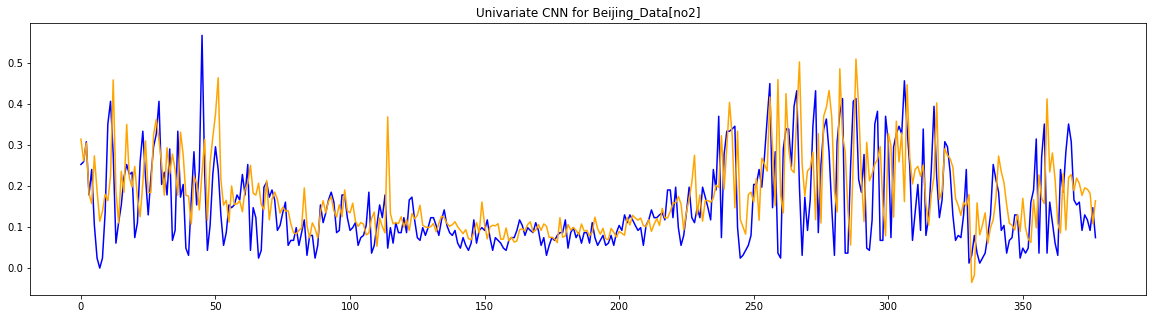

Univariate CNN MSE for Beijing[o3]:0.013917631
Univariate CNN RMSE for Beijing[o3]:0.11797300766846788
Univariate CNN MAE for Beijing[o3]:0.09200098


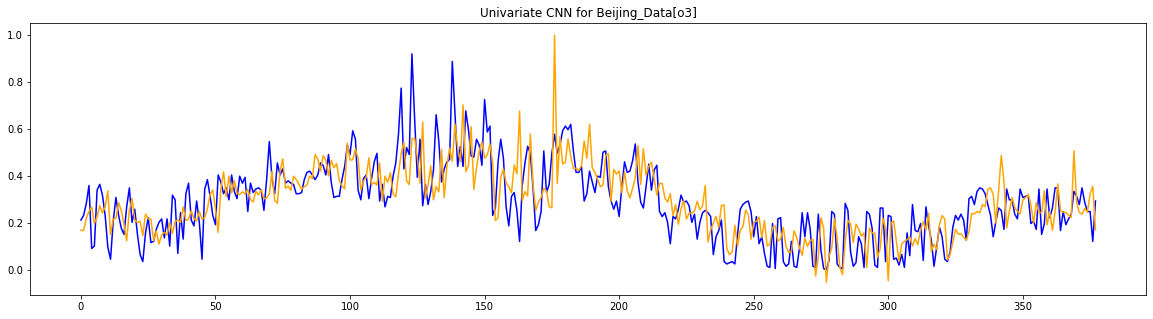

Univariate CNN MSE for Beijing[pm10]:0.0031113597
Univariate CNN RMSE for Beijing[pm10]:0.05577956313299403
Univariate CNN MAE for Beijing[pm10]:0.02075821


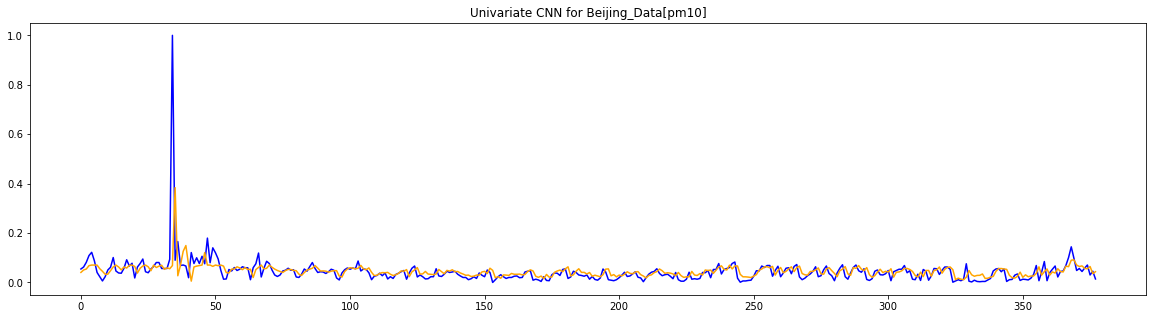

Univariate CNN MSE for Beijing[pm25]:0.010766896
Univariate CNN RMSE for Beijing[pm25]:0.10376365654325759
Univariate CNN MAE for Beijing[pm25]:0.08144704


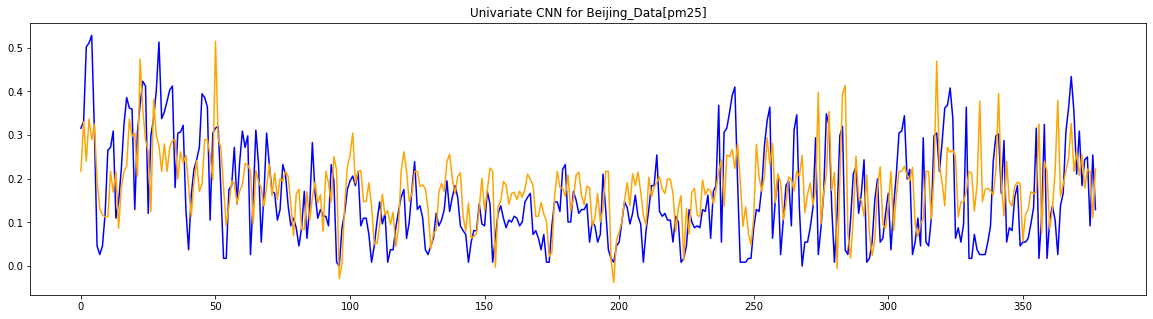

Univariate CNN MSE for Beijing[so2]:0.00017725775
Univariate CNN RMSE for Beijing[so2]:0.013313818104197244
Univariate CNN MAE for Beijing[so2]:0.010590924


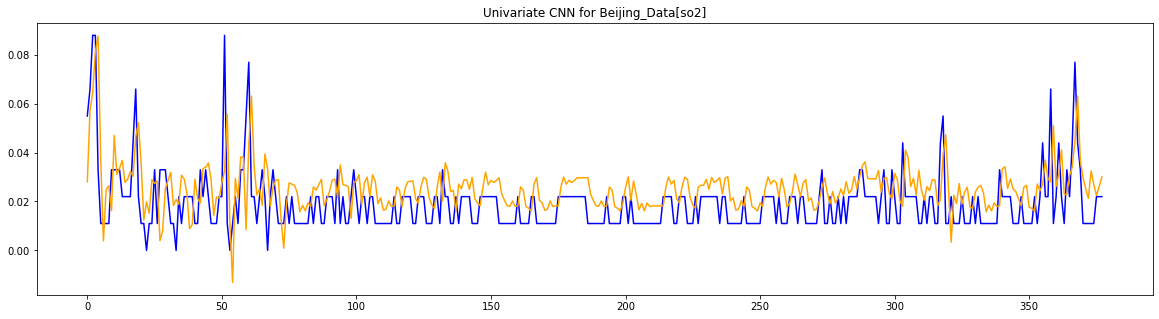

Multivariate CNN MSE for Beijing[o3]:0.0006739355
Multivariate CNN RMSE for Beijing[o3]:0.025960268022616386
Multivariate CNN MAE for Beijing[o3]:0.020252535


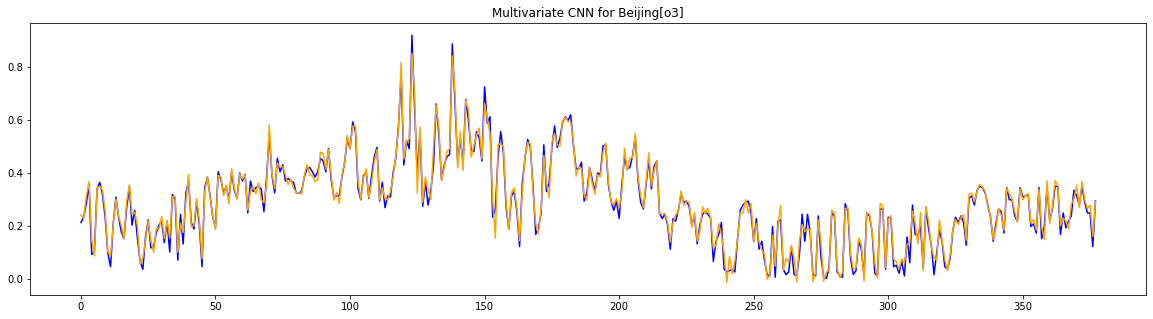

Multivariate CNN MSE for Beijing[no2]:0.0005387138
Multivariate CNN RMSE for Beijing[no2]:0.02321020944771828
Multivariate CNN MAE for Beijing[no2]:0.017521657


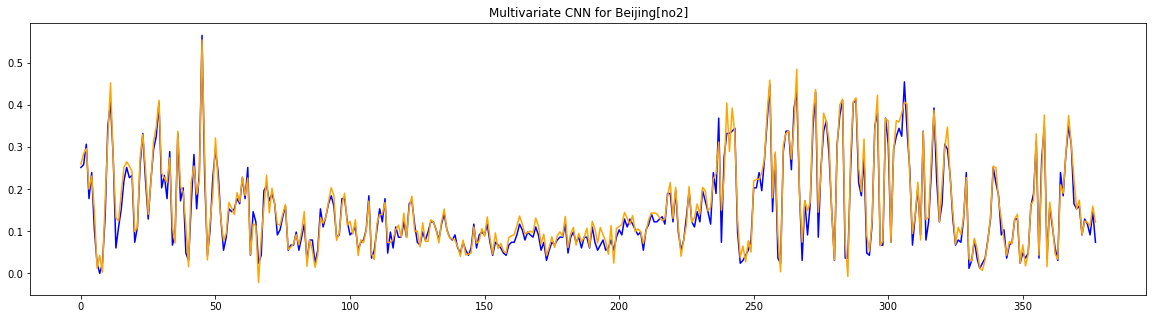

Multivariate CNN MSE for Beijing[so2]:8.434235e-05
Multivariate CNN RMSE for Beijing[so2]:0.009183808996861574
Multivariate CNN MAE for Beijing[so2]:0.0073649366


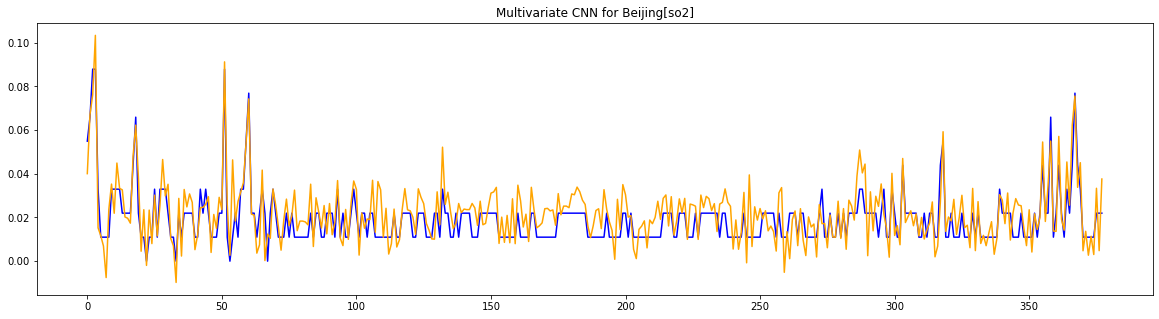

Multivariate CNN MSE for Beijing[pm10]:0.00022567307
Multivariate CNN RMSE for Beijing[pm10]:0.015022418775618957
Multivariate CNN MAE for Beijing[pm10]:0.009464631


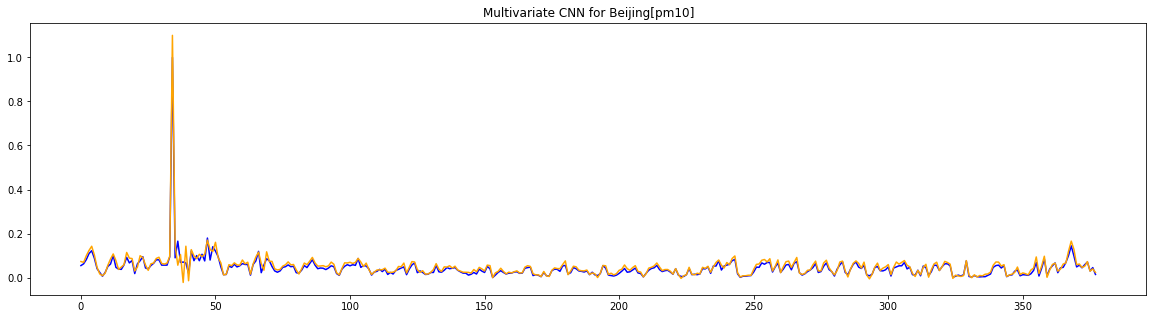

Multivariate CNN MSE for Beijing[pm25]:0.0009522187
Multivariate CNN RMSE for Beijing[pm25]:0.030858041373842685
Multivariate CNN MAE for Beijing[pm25]:0.025422368


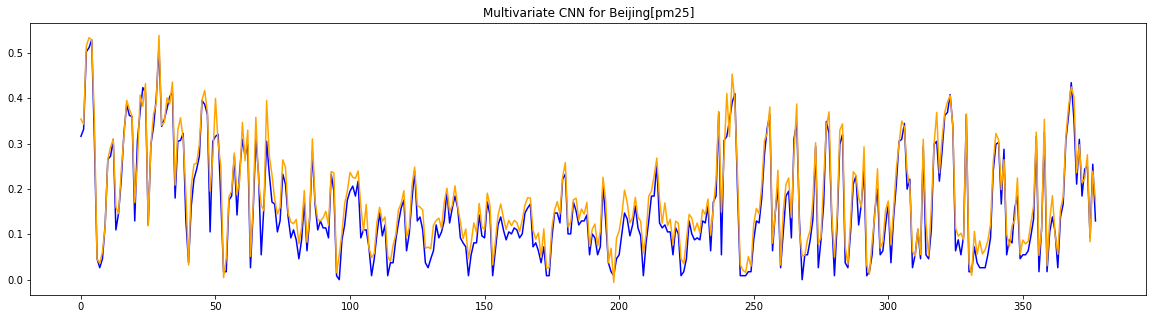

In [18]:
n_steps=7

pred_ucnn,test_ucnn = Uni_CNN()
pred_mcnn,test_mcnn = Multi_CNN()

Univariate LSTM MSE for Beijing[no2]:0.007632368
Univariate LSTM RMSE for Beijing[no2]:0.08736342357399611
Univariate LSTM MAE for Beijing[no2]:0.06634359


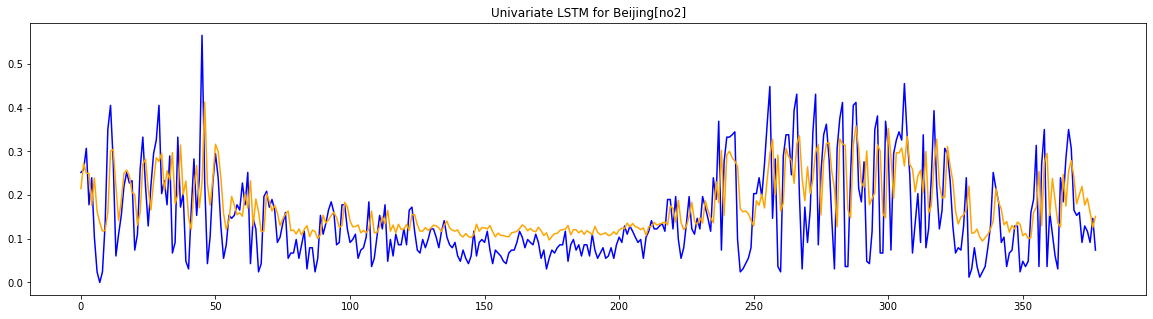

Univariate LSTM MSE for Beijing[o3]:0.010040964
Univariate LSTM RMSE for Beijing[o3]:0.10020461067199973
Univariate LSTM MAE for Beijing[o3]:0.07975321


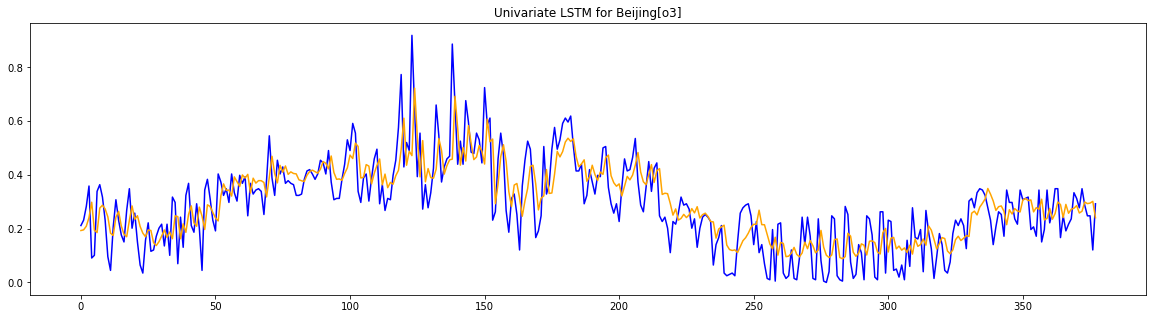

Univariate LSTM MSE for Beijing[pm10]:0.0030765631
Univariate LSTM RMSE for Beijing[pm10]:0.05546677495234058
Univariate LSTM MAE for Beijing[pm10]:0.020524124


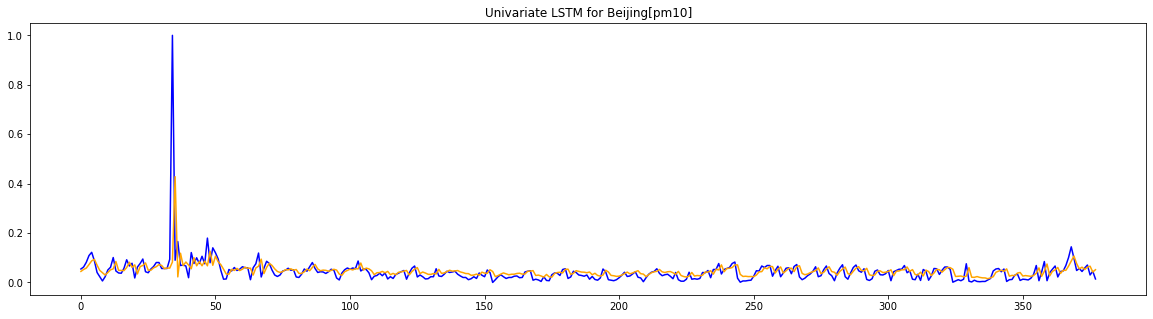

Univariate LSTM MSE for Beijing[pm25]:0.009246865
Univariate LSTM RMSE for Beijing[pm25]:0.09616062233275705
Univariate LSTM MAE for Beijing[pm25]:0.078092195


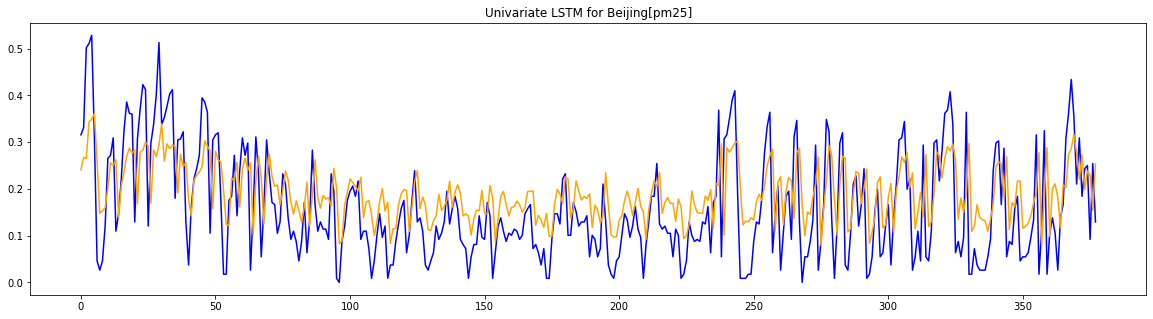

Univariate LSTM MSE for Beijing[so2]:0.00013079285
Univariate LSTM RMSE for Beijing[so2]:0.011436470036825389
Univariate LSTM MAE for Beijing[so2]:0.008009481


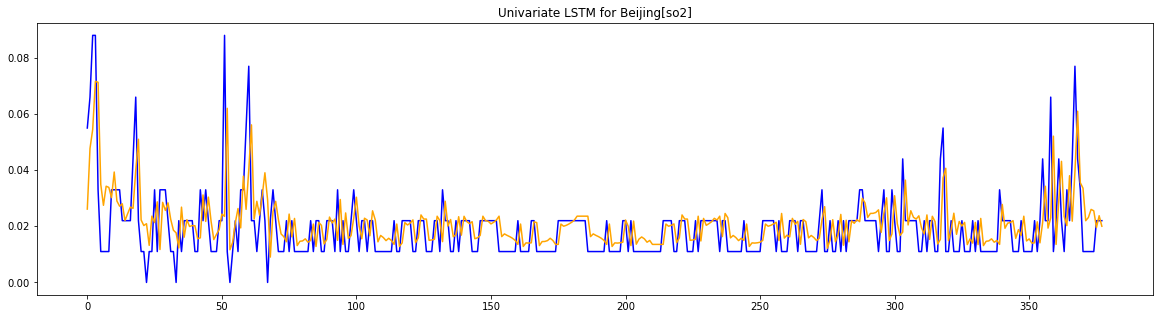

Multivariate LSTM MSE for Beijing[o3]:0.00015304277
Multivariate LSTM RMSE for Beijing[o3]:0.012371045588111116
Multivariate LSTM MAE for Beijing[o3]:0.0119322315


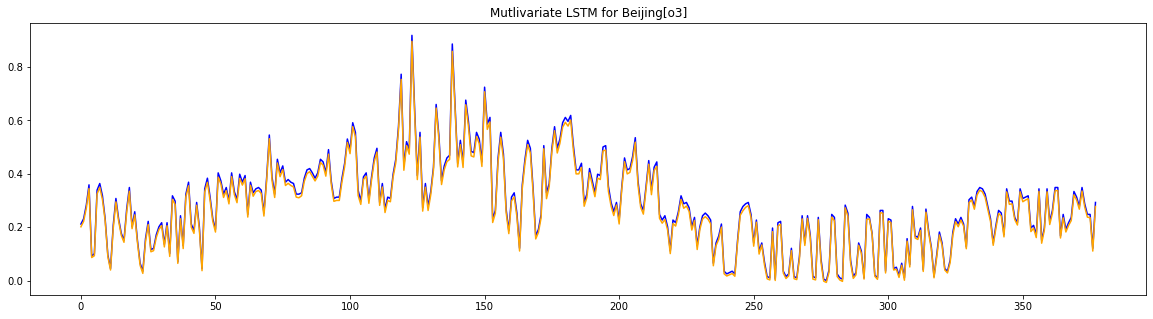

Multivariate LSTM MSE for Beijing[no2]:3.6828584e-05
Multivariate LSTM RMSE for Beijing[no2]:0.0060686558386907384
Multivariate LSTM MAE for Beijing[no2]:0.005543677


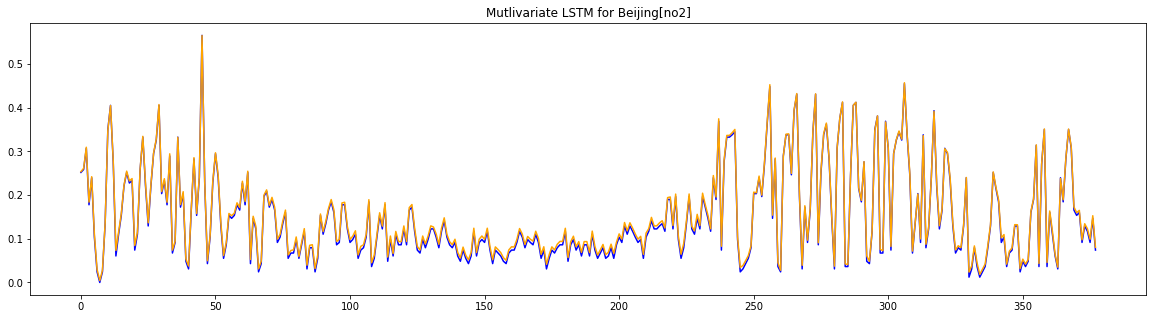

Multivariate LSTM MSE for Beijing[so2]:2.7839395e-05
Multivariate LSTM RMSE for Beijing[so2]:0.0052763050076409974
Multivariate LSTM MAE for Beijing[so2]:0.0051849457


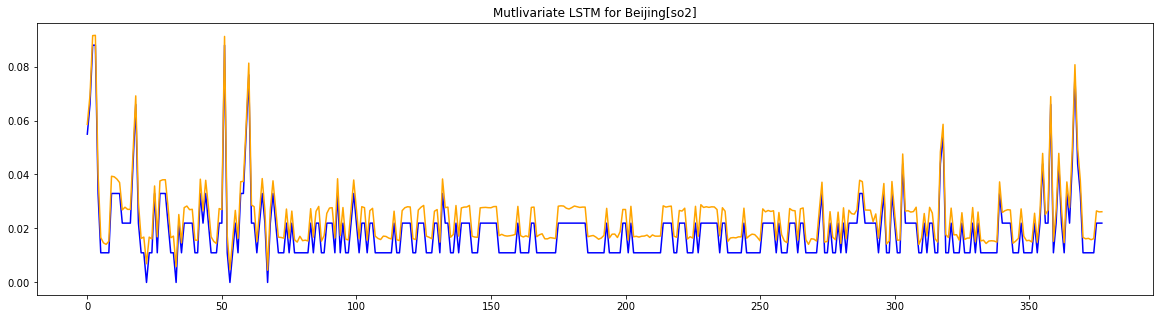

Multivariate LSTM MSE for Beijing[pm10]:2.7202717e-05
Multivariate LSTM RMSE for Beijing[pm10]:0.0052156224287803424
Multivariate LSTM MAE for Beijing[pm10]:0.004969963


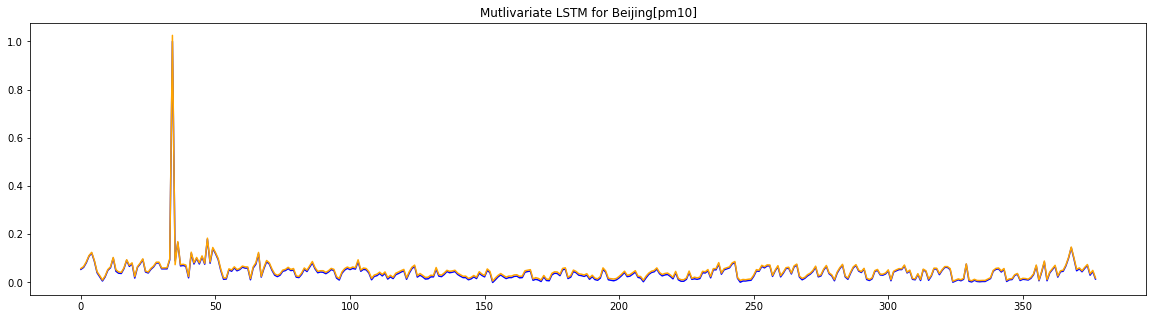

Multivariate LSTM MSE for Beijing[pm25]:6.4445685e-06
Multivariate LSTM RMSE for Beijing[pm25]:0.0025386154687958066
Multivariate LSTM MAE for Beijing[pm25]:0.002038172


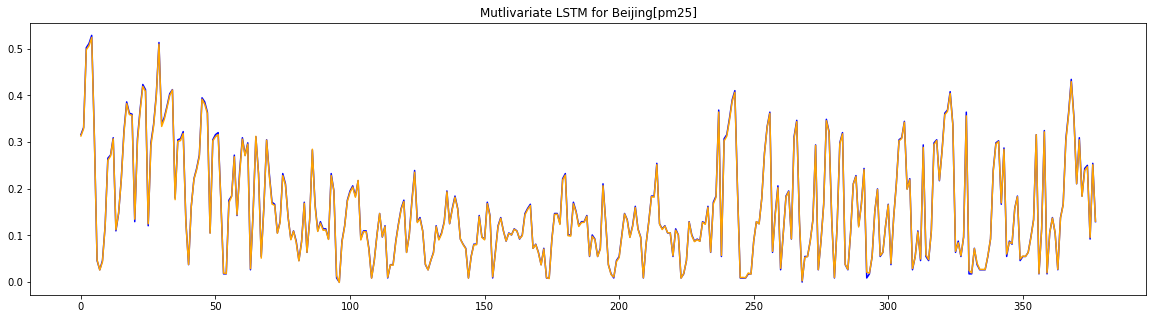

In [19]:
pred_ulstm,test_ulstm = Uni_LSTM()
pred_mlstm,test_mlstm = Multi_LSTM()

# Weekly seasonal predictions

In [20]:
Beijing_Data_uni.index = pd.to_datetime(Beijing_Data_uni.index)
Beijing_Data_uni = Beijing_Data_uni.resample("1w").mean().bfill()

Beijing_o3.index = pd.to_datetime(Beijing_o3.index)
Beijing_weekly_o3 = Beijing_o3.resample("1w").mean().bfill()

Beijing_no2.index = pd.to_datetime(Beijing_no2.index)
Beijing_weekly_no2 = Beijing_no2.resample("1w").mean().bfill()

Beijing_so2.index = pd.to_datetime(Beijing_so2.index)
Beijing_weekly_so2 = Beijing_so2.resample("1w").mean().bfill()

Beijing_pm10.index = pd.to_datetime(Beijing_pm10.index)
Beijing_weekly_pm10 = Beijing_pm10.resample("1w").mean().bfill()

Beijing_pm25.index = pd.to_datetime(Beijing_pm25.index)
Beijing_weekly_pm25 = Beijing_pm25.resample("1w").mean().bfill()

datasets = [Beijing_weekly_o3.iloc[1: , :], Beijing_weekly_no2.iloc[1: , :], 
            Beijing_weekly_so2.iloc[1: , :], Beijing_weekly_pm10.iloc[1: , :],
            Beijing_weekly_pm25.iloc[1: , :]]


Univariate CNN MSE for Beijing[no2]:0.0058814716
Univariate CNN RMSE for Beijing[no2]:0.07669075276332425
Univariate CNN MAE for Beijing[no2]:0.05977027


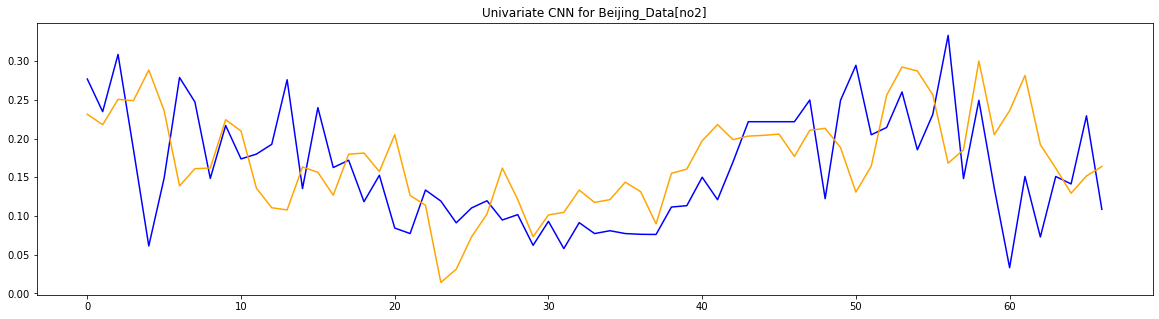

Univariate CNN MSE for Beijing[o3]:0.010381578
Univariate CNN RMSE for Beijing[o3]:0.10189002667809906
Univariate CNN MAE for Beijing[o3]:0.076024786


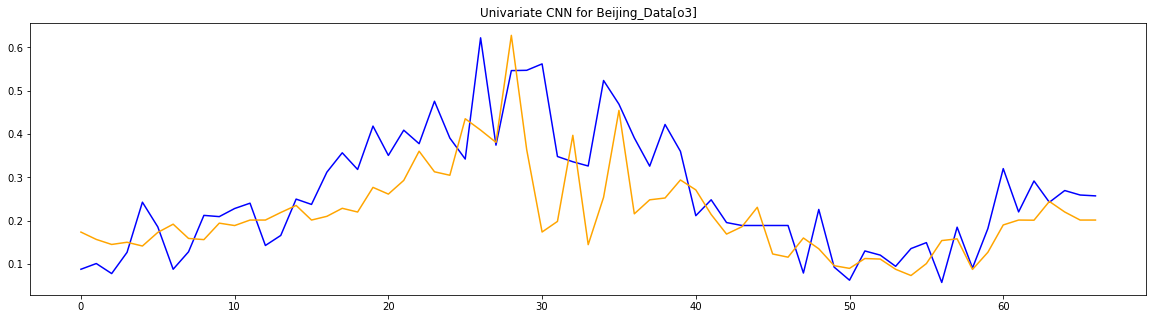

Univariate CNN MSE for Beijing[pm10]:0.000659225
Univariate CNN RMSE for Beijing[pm10]:0.025675377011871177
Univariate CNN MAE for Beijing[pm10]:0.016497834


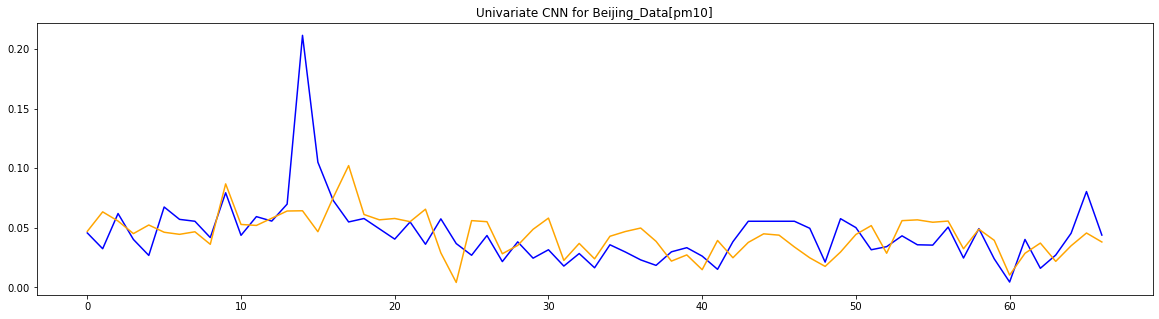

Univariate CNN MSE for Beijing[pm25]:0.006463069
Univariate CNN RMSE for Beijing[pm25]:0.08039321490695195
Univariate CNN MAE for Beijing[pm25]:0.06629178


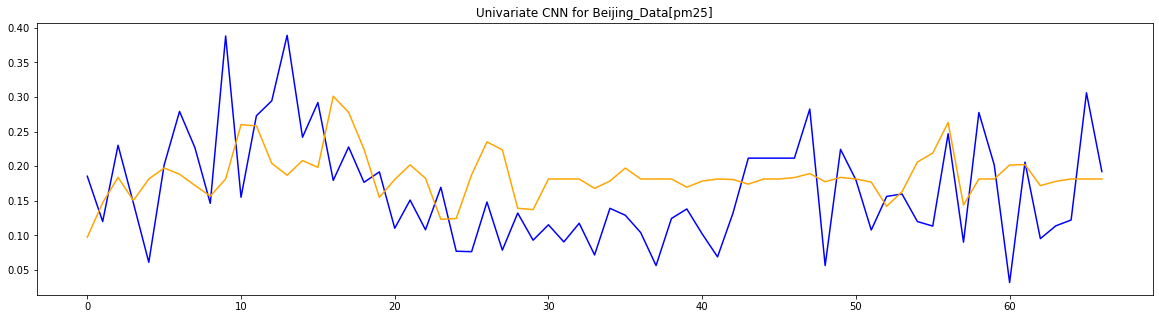

Univariate CNN MSE for Beijing[so2]:0.00011684486
Univariate CNN RMSE for Beijing[so2]:0.010809480005286478
Univariate CNN MAE for Beijing[so2]:0.008012861


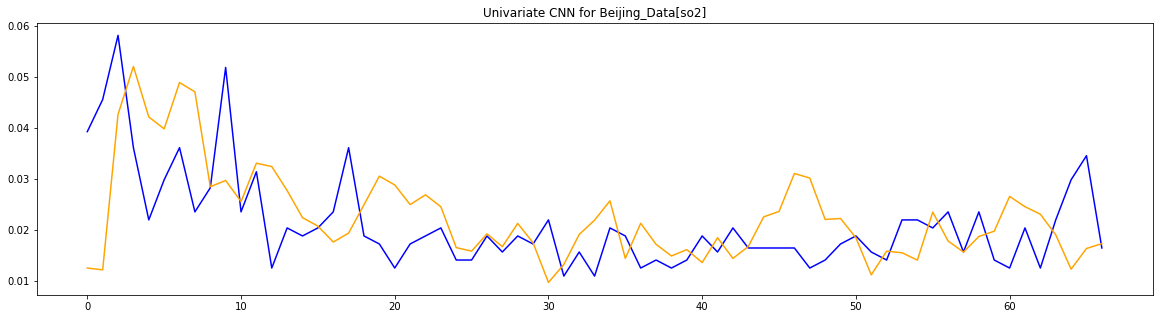

Multivariate CNN MSE for Beijing[o3]:0.01902541
Multivariate CNN RMSE for Beijing[o3]:0.13793262701108175
Multivariate CNN MAE for Beijing[o3]:0.111757785


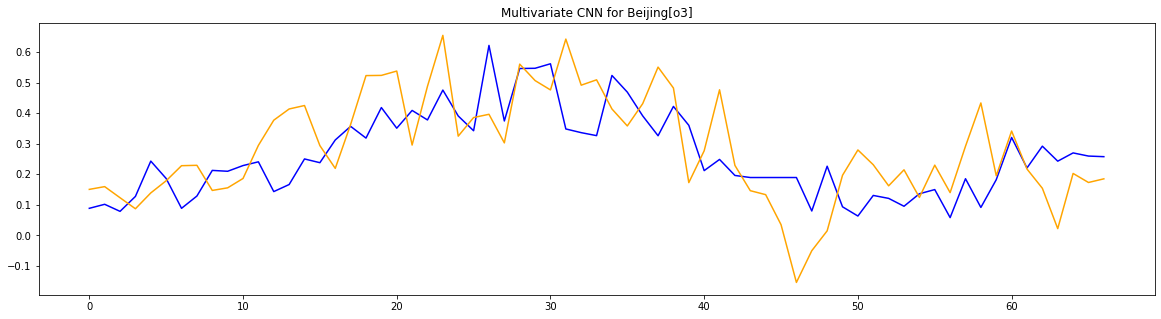

Multivariate CNN MSE for Beijing[no2]:0.01296096
Multivariate CNN RMSE for Beijing[no2]:0.11384621274867072
Multivariate CNN MAE for Beijing[no2]:0.09195617


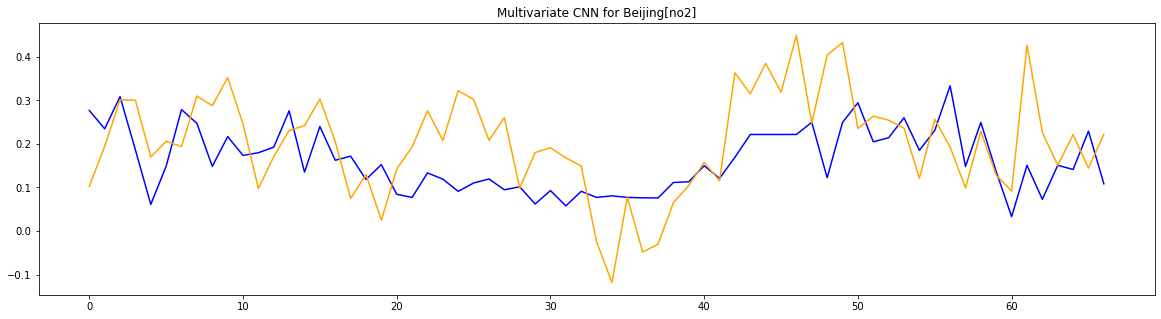

Multivariate CNN MSE for Beijing[so2]:0.0021275184
Multivariate CNN RMSE for Beijing[so2]:0.04612503020839943
Multivariate CNN MAE for Beijing[so2]:0.03893231


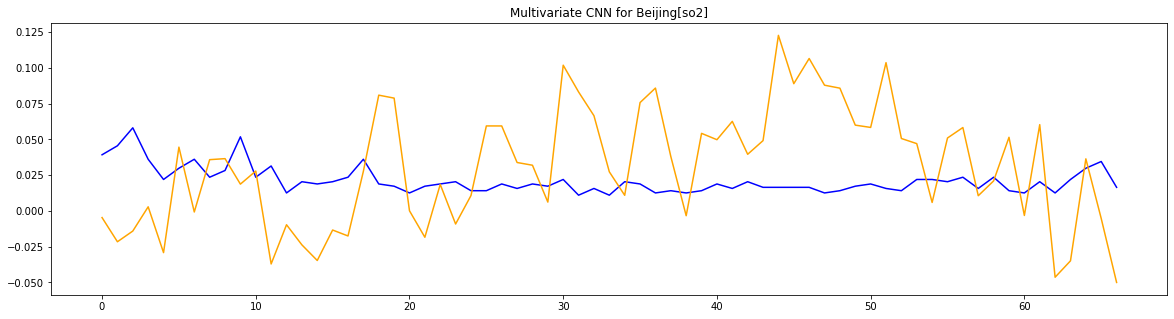

Multivariate CNN MSE for Beijing[pm10]:0.0019088361
Multivariate CNN RMSE for Beijing[pm10]:0.0436902285571898
Multivariate CNN MAE for Beijing[pm10]:0.034265354


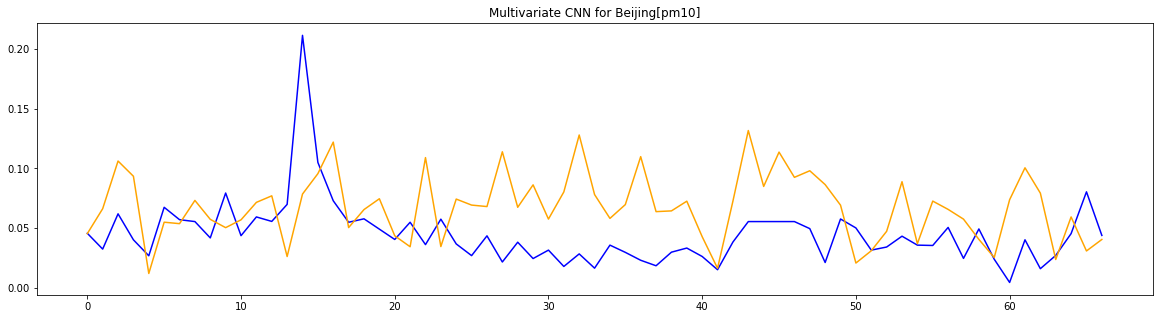

Multivariate CNN MSE for Beijing[pm25]:0.020963116
Multivariate CNN RMSE for Beijing[pm25]:0.144786448321771
Multivariate CNN MAE for Beijing[pm25]:0.12022911


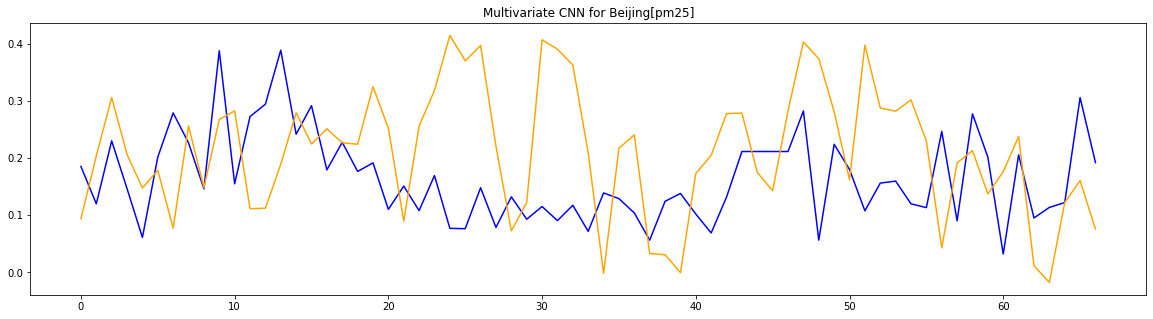

Univariate LSTM MSE for Beijing[no2]:0.0041172504
Univariate LSTM RMSE for Beijing[no2]:0.0641658043080961
Univariate LSTM MAE for Beijing[no2]:0.05177564


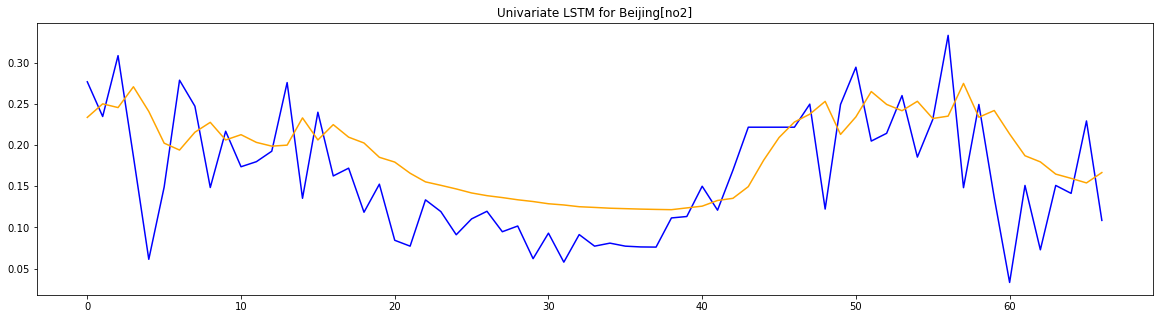

Univariate LSTM MSE for Beijing[o3]:0.005085579
Univariate LSTM RMSE for Beijing[o3]:0.07131324645269424
Univariate LSTM MAE for Beijing[o3]:0.05415056


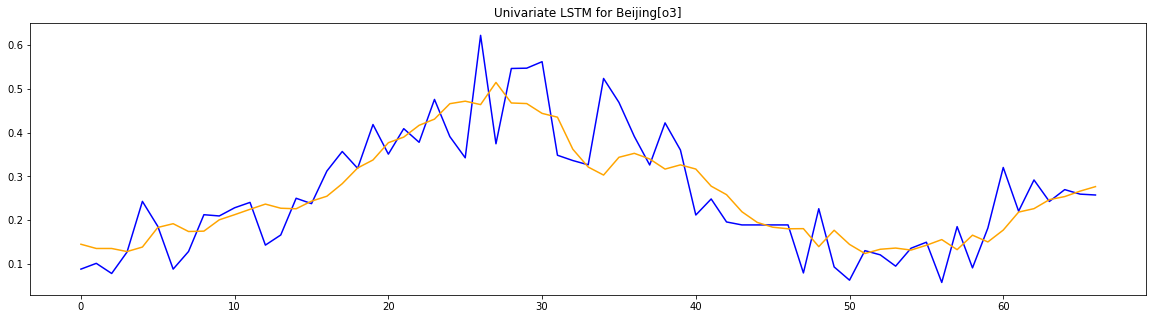

Univariate LSTM MSE for Beijing[pm10]:0.0005623769
Univariate LSTM RMSE for Beijing[pm10]:0.023714487656081504
Univariate LSTM MAE for Beijing[pm10]:0.014601637


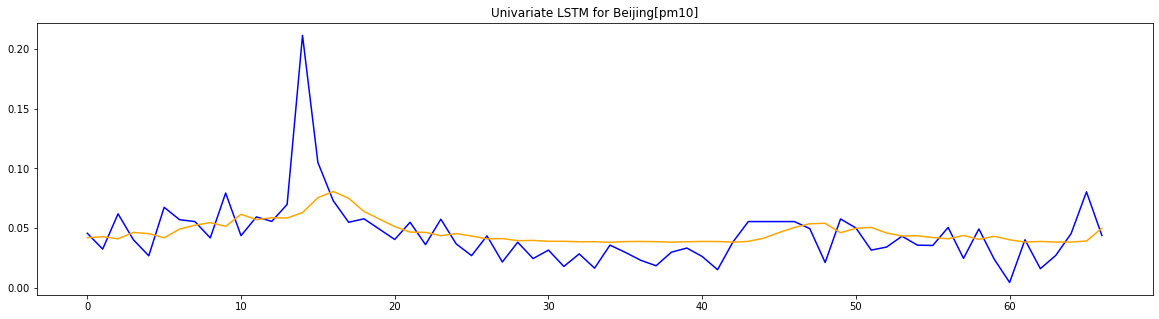

Univariate LSTM MSE for Beijing[pm25]:0.005861087
Univariate LSTM RMSE for Beijing[pm25]:0.07655773488611156
Univariate LSTM MAE for Beijing[pm25]:0.06546496


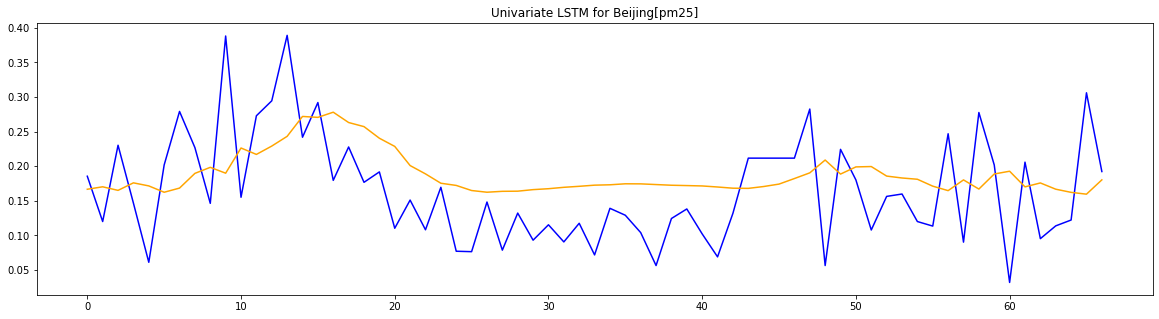

Univariate LSTM MSE for Beijing[so2]:9.79614e-05
Univariate LSTM RMSE for Beijing[so2]:0.00989754504114898
Univariate LSTM MAE for Beijing[so2]:0.008778497


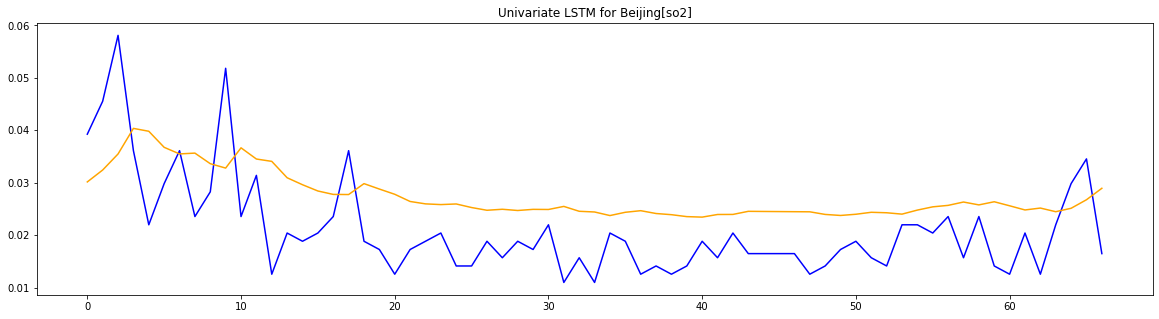

Multivariate LSTM MSE for Beijing[o3]:0.000102904996
Multivariate LSTM RMSE for Beijing[o3]:0.010144209989487915
Multivariate LSTM MAE for Beijing[o3]:0.00897824


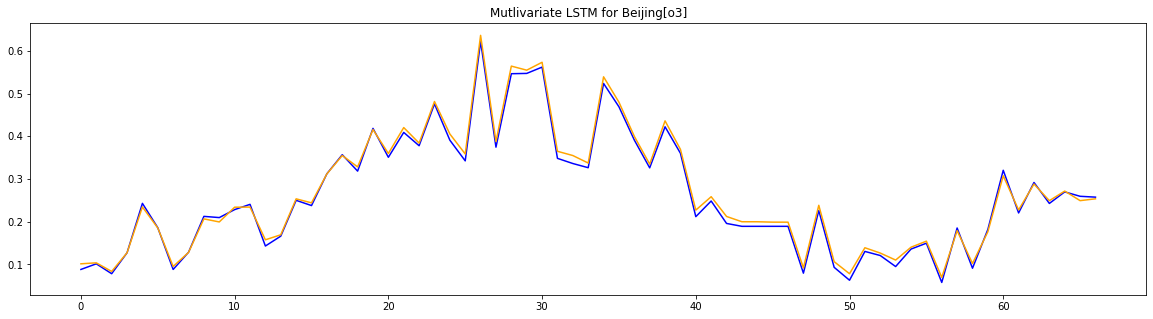

Multivariate LSTM MSE for Beijing[no2]:0.00031988832
Multivariate LSTM RMSE for Beijing[no2]:0.017885422011198325
Multivariate LSTM MAE for Beijing[no2]:0.017120445


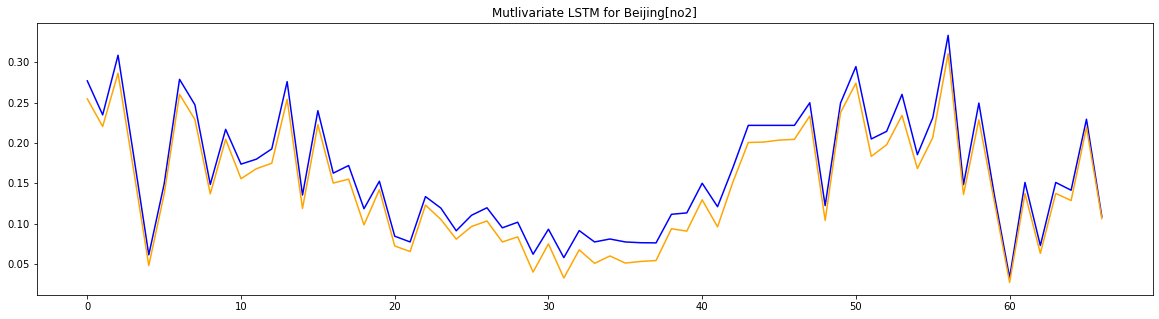

Multivariate LSTM MSE for Beijing[so2]:0.00017508434
Multivariate LSTM RMSE for Beijing[so2]:0.01323194379752281
Multivariate LSTM MAE for Beijing[so2]:0.0118004


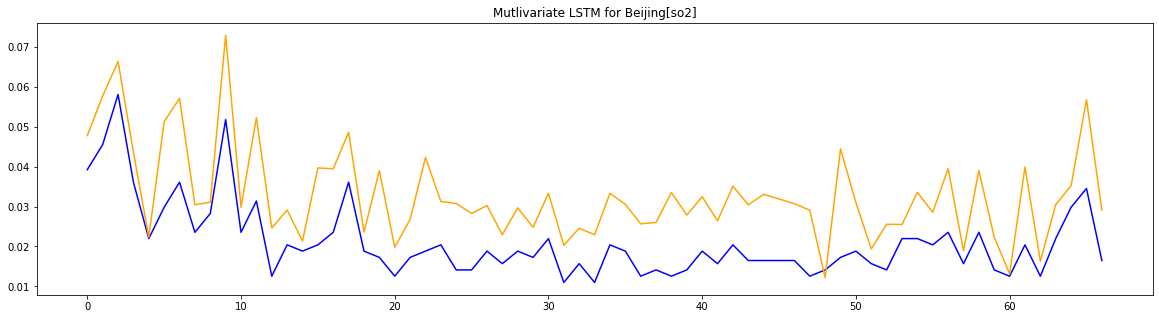

Multivariate LSTM MSE for Beijing[pm10]:0.00012801608
Multivariate LSTM RMSE for Beijing[pm10]:0.011314419098794175
Multivariate LSTM MAE for Beijing[pm10]:0.008587871


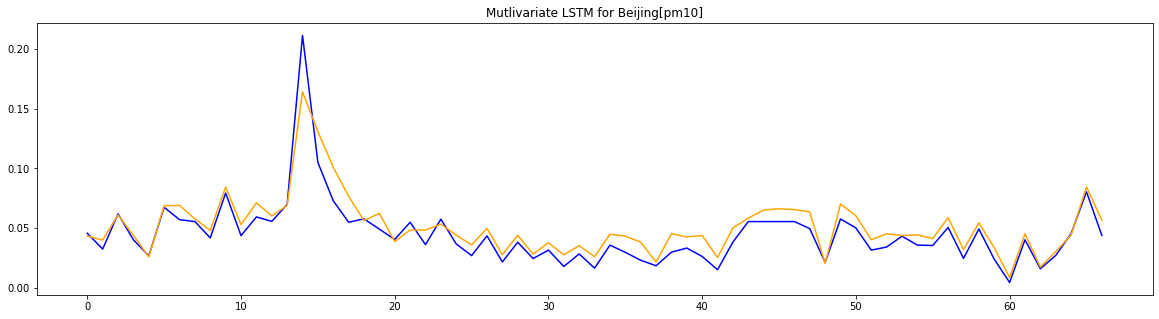

Multivariate LSTM MSE for Beijing[pm25]:2.4629146e-05
Multivariate LSTM RMSE for Beijing[pm25]:0.0049627760001677845
Multivariate LSTM MAE for Beijing[pm25]:0.004055813


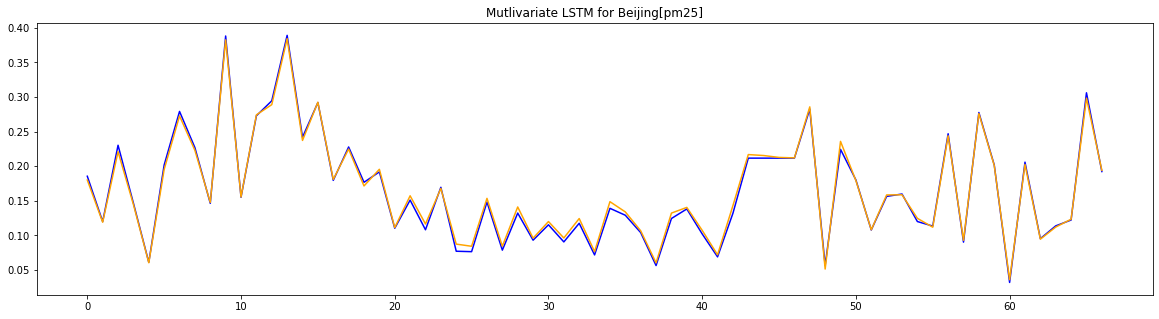

In [21]:
n_steps = 46

pred_ucnn,test_ucnn = Uni_CNN()
pred_mcnn,test_mcnn = Multi_CNN()
pred_ulstm,test_ulstm = Uni_LSTM()
pred_mlstm,test_mlstm = Multi_LSTM()

# Monthly seasonal predictions

In [22]:
Beijing_Data_uni.index = pd.to_datetime(Beijing_Data_uni.index)
Beijing_Data_uni = Beijing_Data_uni.resample("1m").mean().bfill()

In [23]:
Beijing_o3.index = pd.to_datetime(Beijing_o3.index)
Beijing_monthly_o3 = Beijing_o3.resample("1m").mean().bfill()

Beijing_no2.index = pd.to_datetime(Beijing_no2.index)
Beijing_monthly_no2 = Beijing_no2.resample("1m").mean().bfill()

Beijing_so2.index = pd.to_datetime(Beijing_so2.index)
Beijing_monthly_so2 = Beijing_so2.resample("1m").mean().bfill()

Beijing_pm10.index = pd.to_datetime(Beijing_pm10.index)
Beijing_monthly_pm10 = Beijing_pm10.resample("1m").mean().bfill()

Beijing_pm25.index = pd.to_datetime(Beijing_pm25.index)
Beijing_monthly_pm25 = Beijing_pm25.resample("1m").mean().bfill()

datasets = [Beijing_monthly_o3.iloc[1: , :], Beijing_monthly_no2.iloc[1: , :], 
            Beijing_monthly_so2.iloc[1: , :], Beijing_monthly_pm10.iloc[1: , :],
            Beijing_monthly_pm25.iloc[1: , :]]

Univariate CNN MSE for Beijing[no2]:0.0020594408
Univariate CNN RMSE for Beijing[no2]:0.045381062426932677
Univariate CNN MAE for Beijing[no2]:0.03802348


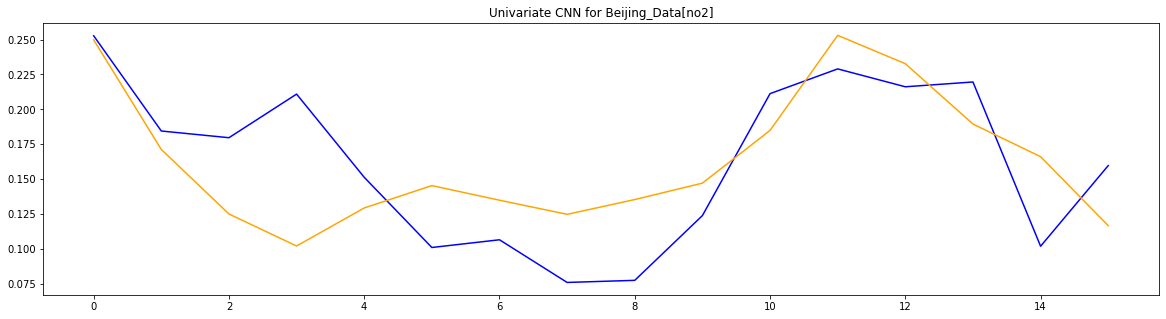

Univariate CNN MSE for Beijing[o3]:0.004449669
Univariate CNN RMSE for Beijing[o3]:0.06670583787080593
Univariate CNN MAE for Beijing[o3]:0.05338525


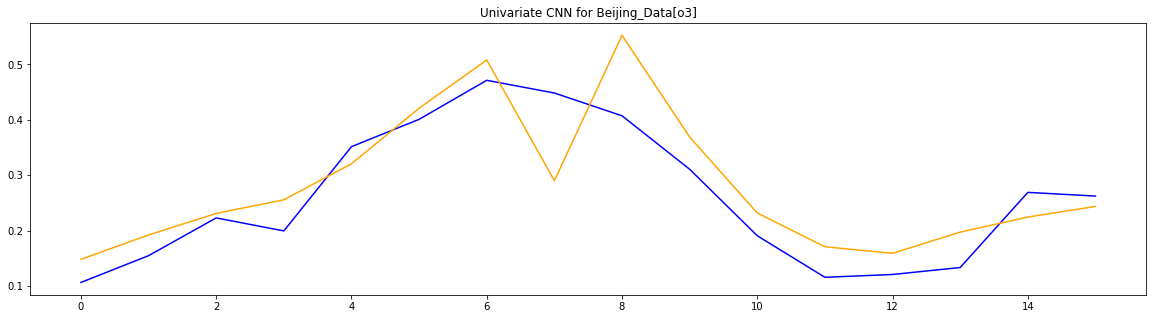

Univariate CNN MSE for Beijing[pm10]:0.00072517025
Univariate CNN RMSE for Beijing[pm10]:0.026928985279584493
Univariate CNN MAE for Beijing[pm10]:0.020354578


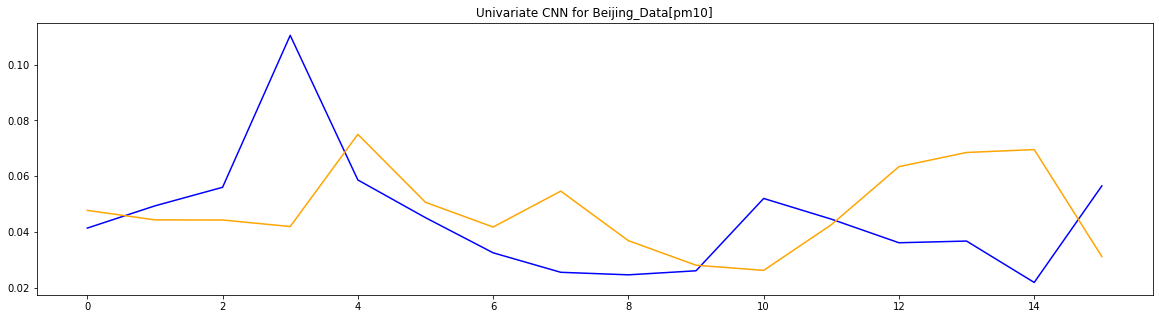

Univariate CNN MSE for Beijing[pm25]:0.00675351
Univariate CNN RMSE for Beijing[pm25]:0.08217974120311576
Univariate CNN MAE for Beijing[pm25]:0.06908822


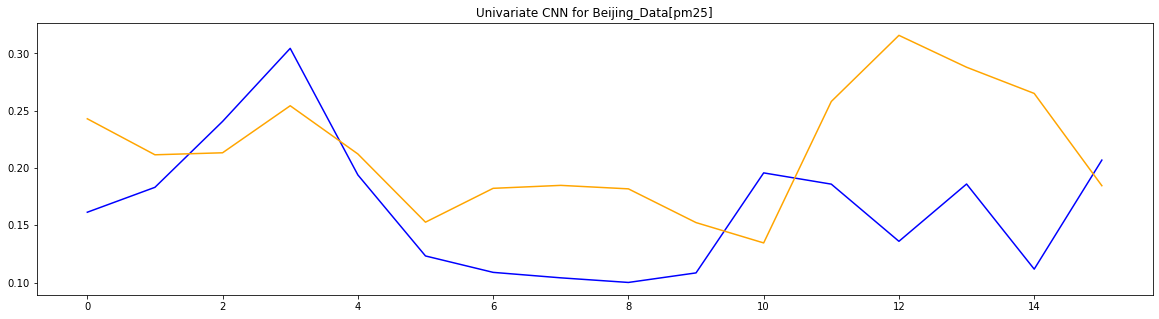

Univariate CNN MSE for Beijing[so2]:3.5941062e-05
Univariate CNN RMSE for Beijing[so2]:0.005995086519700704
Univariate CNN MAE for Beijing[so2]:0.005187702


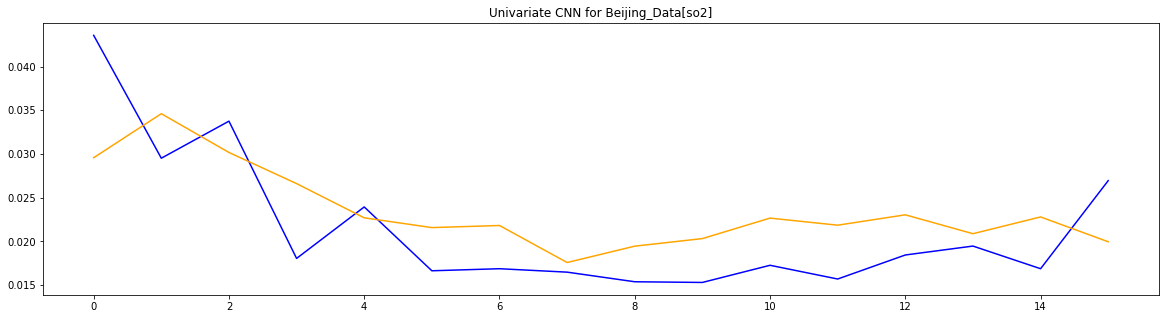

Multivariate CNN MSE for Beijing[o3]:0.0026068813
Multivariate CNN RMSE for Beijing[o3]:0.05105762741012592
Multivariate CNN MAE for Beijing[o3]:0.039292693


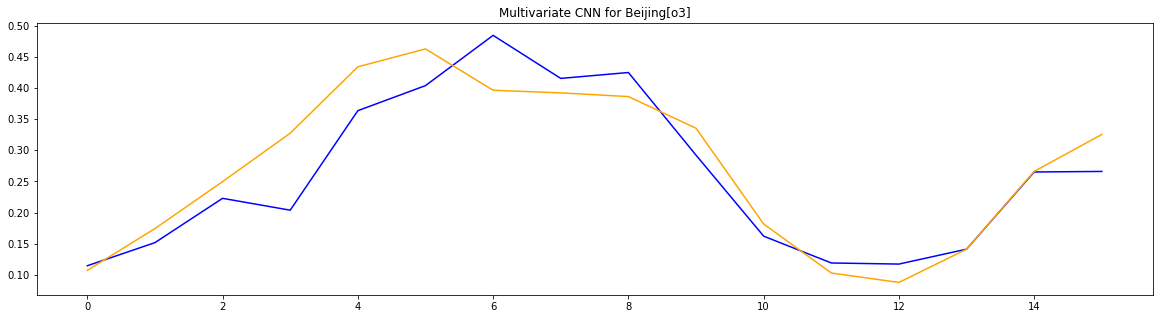

Multivariate CNN MSE for Beijing[no2]:0.0012777362
Multivariate CNN RMSE for Beijing[no2]:0.035745435447288004
Multivariate CNN MAE for Beijing[no2]:0.031166589


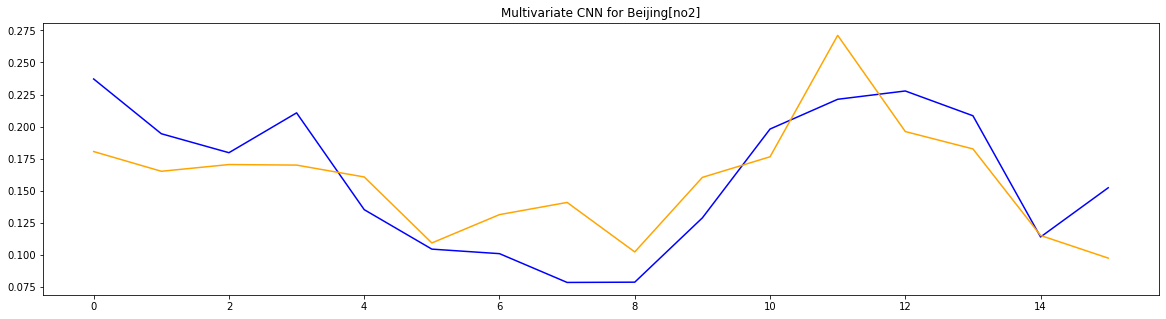

Multivariate CNN MSE for Beijing[so2]:0.00038755493
Multivariate CNN RMSE for Beijing[so2]:0.019686414860440603
Multivariate CNN MAE for Beijing[so2]:0.014687125


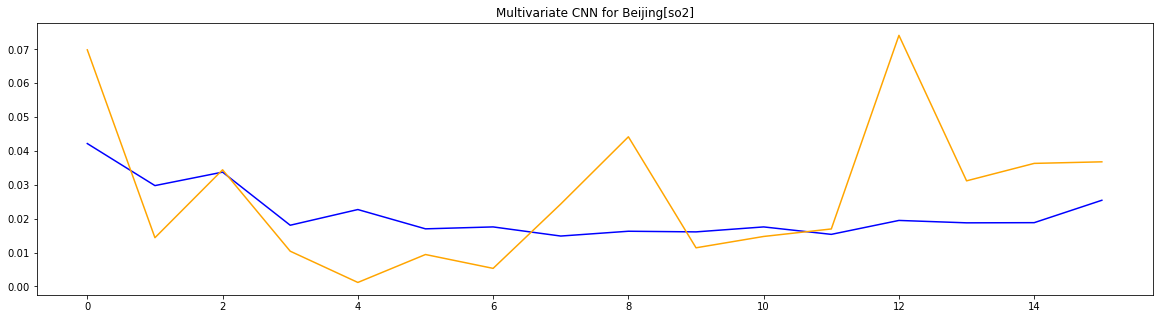

Multivariate CNN MSE for Beijing[pm10]:0.00068309903
Multivariate CNN RMSE for Beijing[pm10]:0.026136163288600037
Multivariate CNN MAE for Beijing[pm10]:0.021403812


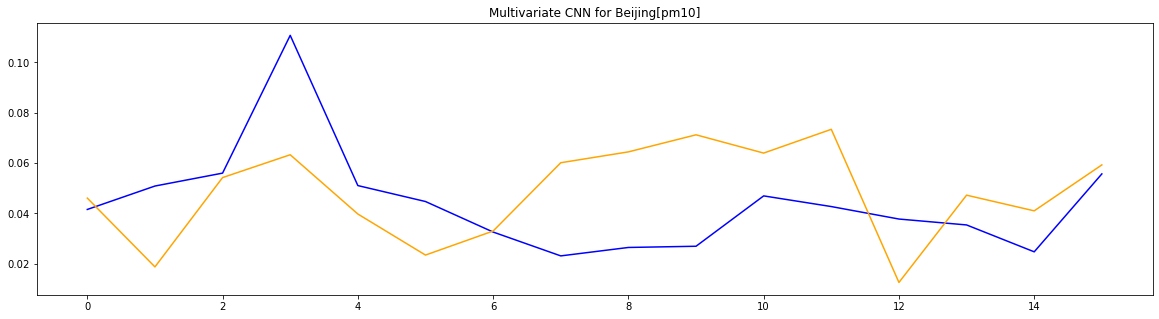

Multivariate CNN MSE for Beijing[pm25]:0.0014577112
Multivariate CNN RMSE for Beijing[pm25]:0.038179984495312555
Multivariate CNN MAE for Beijing[pm25]:0.030538129


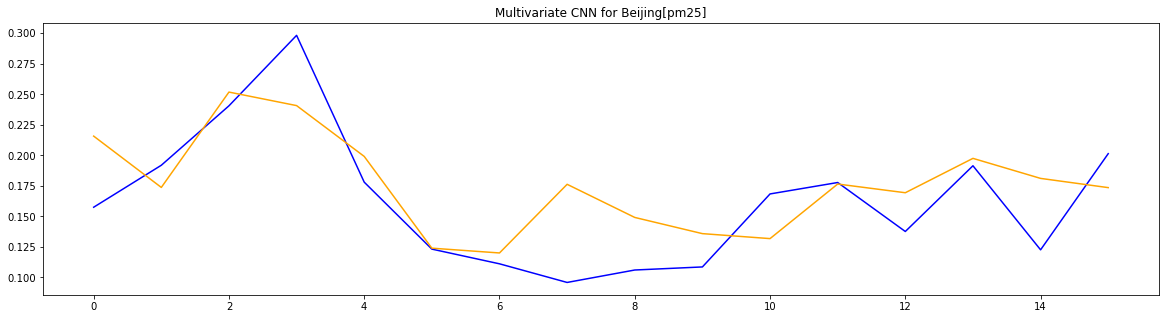

Univariate LSTM MSE for Beijing[no2]:0.0030024927
Univariate LSTM RMSE for Beijing[no2]:0.054795006259220284
Univariate LSTM MAE for Beijing[no2]:0.045180168


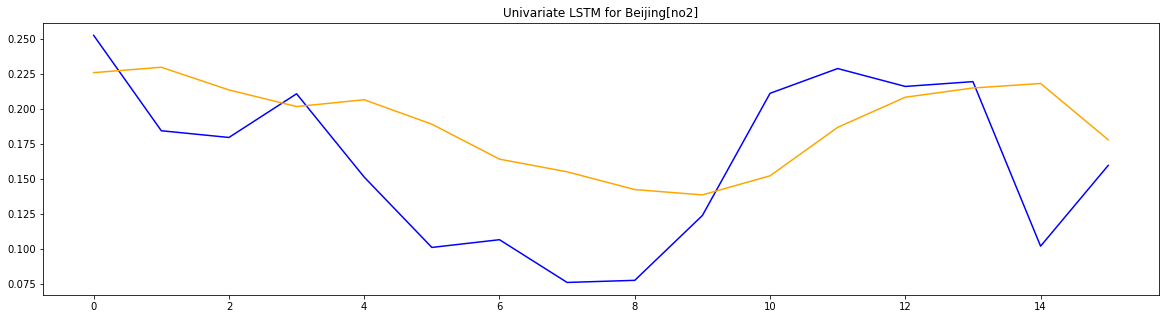

Univariate LSTM MSE for Beijing[o3]:0.0037872295
Univariate LSTM RMSE for Beijing[o3]:0.0615404707172542
Univariate LSTM MAE for Beijing[o3]:0.053099733


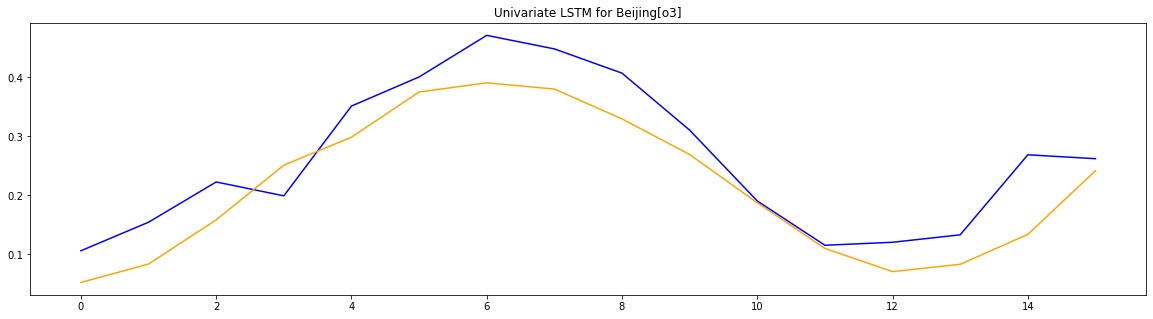

Univariate LSTM MSE for Beijing[pm10]:0.00044380763
Univariate LSTM RMSE for Beijing[pm10]:0.02106674223679125
Univariate LSTM MAE for Beijing[pm10]:0.01589833


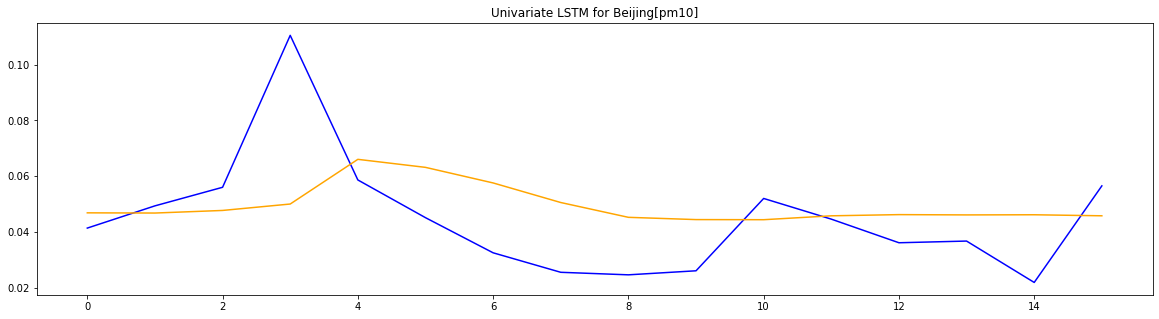

Univariate LSTM MSE for Beijing[pm25]:0.03052845
Univariate LSTM RMSE for Beijing[pm25]:0.1747239261942567
Univariate LSTM MAE for Beijing[pm25]:0.16561761


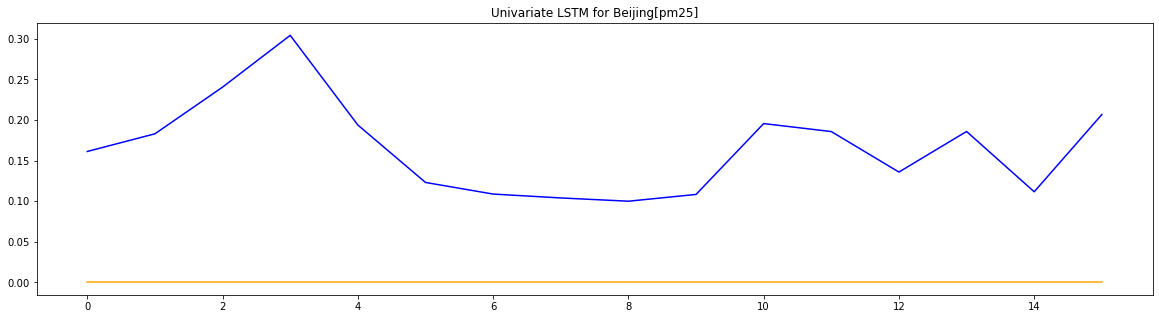

Univariate LSTM MSE for Beijing[so2]:0.00013321292
Univariate LSTM RMSE for Beijing[so2]:0.01154179005688345
Univariate LSTM MAE for Beijing[so2]:0.01065854


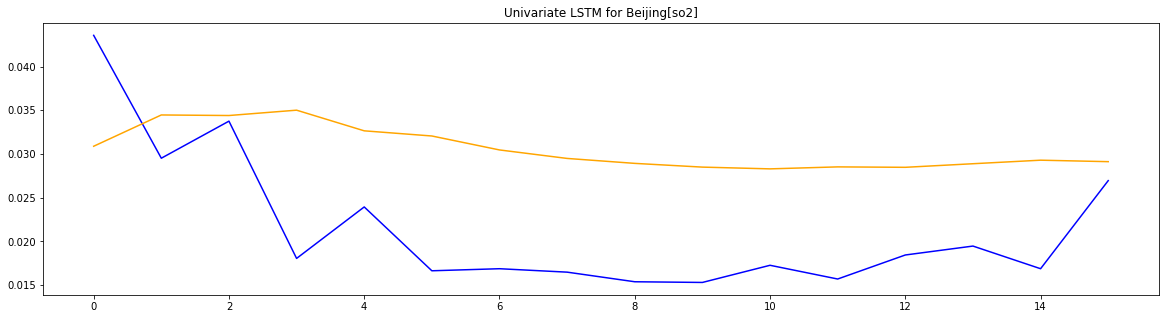

Multivariate LSTM MSE for Beijing[o3]:0.00037059435
Multivariate LSTM RMSE for Beijing[o3]:0.019250827325509416
Multivariate LSTM MAE for Beijing[o3]:0.015674368


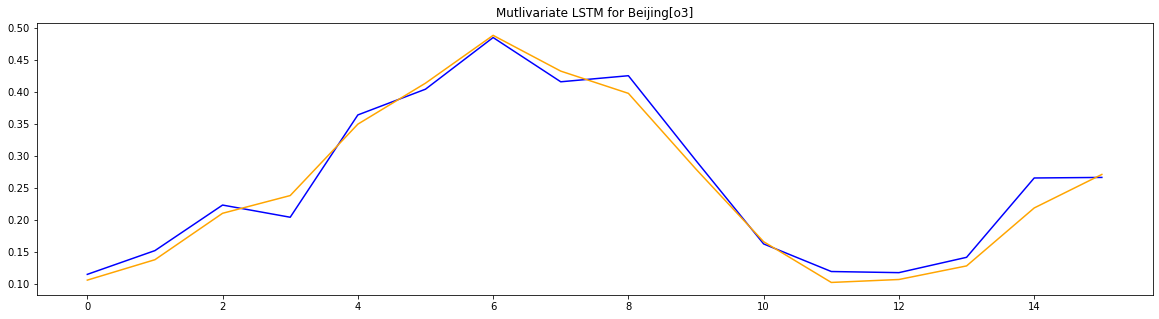

Multivariate LSTM MSE for Beijing[no2]:0.00045707298
Multivariate LSTM RMSE for Beijing[no2]:0.021379265183130144
Multivariate LSTM MAE for Beijing[no2]:0.01768361


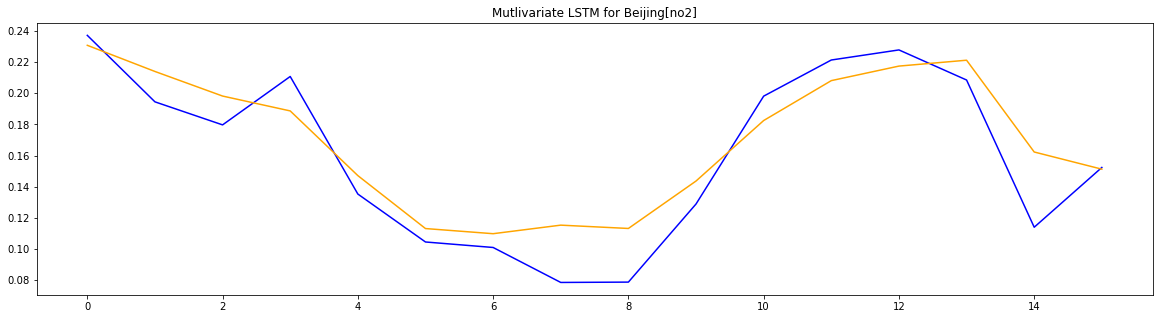

Multivariate LSTM MSE for Beijing[so2]:0.00018356589
Multivariate LSTM RMSE for Beijing[so2]:0.013548649059881413
Multivariate LSTM MAE for Beijing[so2]:0.011541858


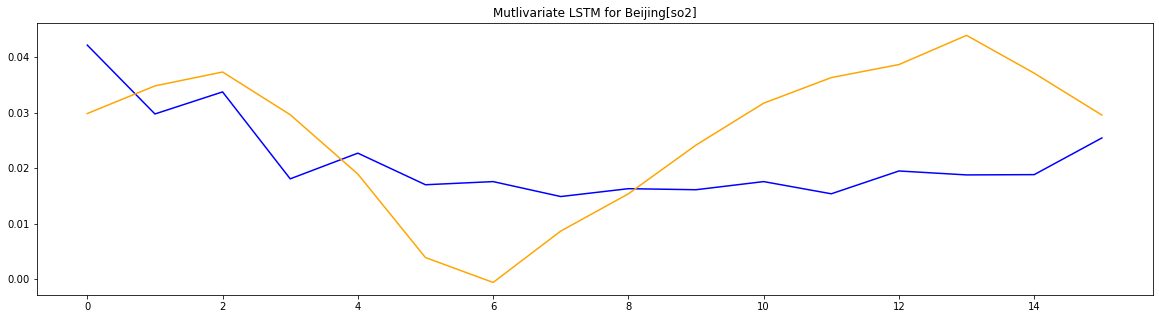

Multivariate LSTM MSE for Beijing[pm10]:0.00027718447
Multivariate LSTM RMSE for Beijing[pm10]:0.01664885803339993
Multivariate LSTM MAE for Beijing[pm10]:0.012202481


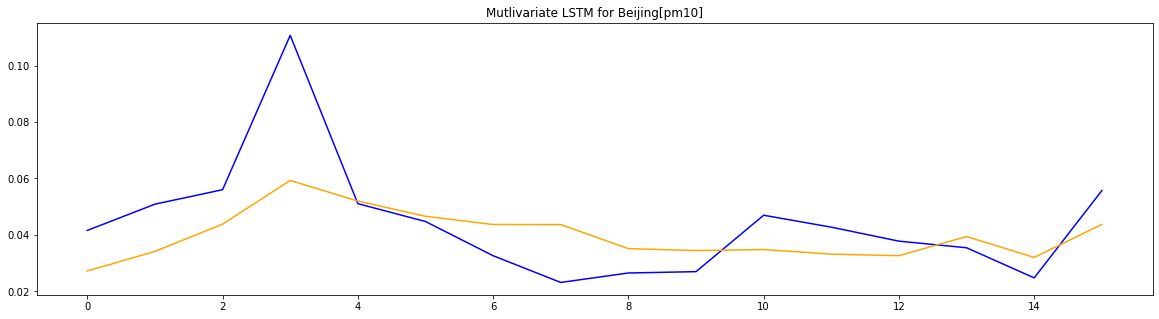

Multivariate LSTM MSE for Beijing[pm25]:0.0013773466
Multivariate LSTM RMSE for Beijing[pm25]:0.037112620174160234
Multivariate LSTM MAE for Beijing[pm25]:0.032723647


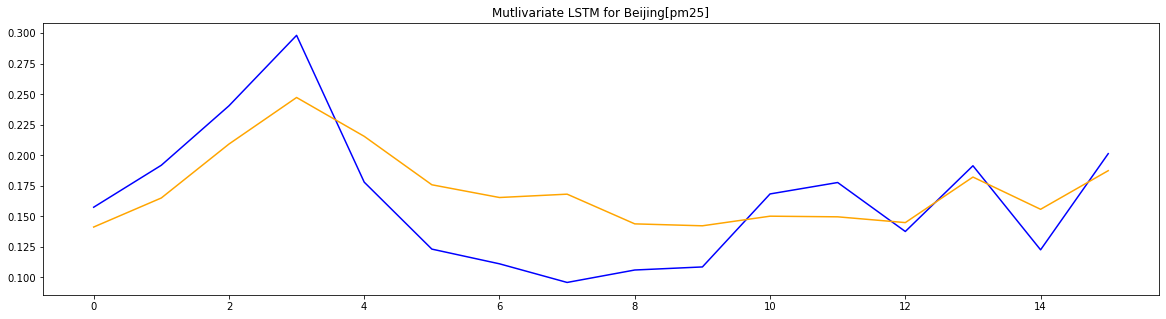

In [24]:
n_steps = 11

pred_ucnn,test_ucnn = Uni_CNN()
pred_mcnn,test_mcnn = Multi_CNN()
pred_ulstm,test_ulstm = Uni_LSTM()
pred_mlstm,test_mlstm = Multi_LSTM()